In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)


In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/itrp/itrpnet')

from trainer import TCGAPreTrainer

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [3]:
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    return dfd
    
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)
df_cancer = tcga_label[['cancer_type']]

df_tmb = mutation[['tmb']]
df_msi = mutation[['msi']]
df_cnv= mutation[['cnv']]
df_ctc = tcga_label[['cancer_type']]

df_msi = onehot(df_msi.msi)
df_ctc = onehot(df_ctc.cancer_type)
df_rps = onehot(tcga_label['treatment_outcome'])
df_ost = np.log10(tcga_label[['os_time']]+1)
df_oss = onehot(tcga_label.os_status)

df_pft = np.log10(tcga_label[['pfi_time']]+1)
df_pfs = onehot(tcga_label.pfi_status)

In [4]:

tasks = {'msi': df_msi, 
         'tmb': df_tmb, 
         'cnv':df_cnv, 
         'ctc':df_ctc, 
         'rps':df_rps, 
         'ost':df_ost,
         'oss':df_oss,
         'pft':df_pft,
         'pfs':df_pfs}


tasks_type_map = {'msi': 'c', 'tmb': 'r', 
                  'cnv':'r', 'ctc':'c', 
                  'rps':'c', 'ost':'r', 
                  'oss':'c', 'pft':'r', 'pfs':'c'}

In [5]:
tasks = {'tmb': df_tmb}


In [6]:
for task_name, df_task  in tasks.items():
    task_type = tasks_type_map[task_name]


In [7]:
test_idx = df_cancer.groupby('cancer_type').apply(lambda x:x.sample(frac=0.2, random_state=1).index.tolist()).tolist()
test_idx = list(chain(*test_idx))
train_idx = df_cancer[~df_cancer.index.isin(test_idx)].index

df_task_train = df_task.loc[train_idx]
df_tpm_train = df_tpm.loc[train_idx]

df_task_test = df_task.loc[test_idx]
df_tpm_test = df_tpm.loc[test_idx]

print(len(df_tpm_train), len(df_tpm_test), len(df_tpm_normal))

8146 2038 714


In [8]:
# ## parameters
# device='cuda'
# lr = 1e-5
# weight_decay = 1e-4
# epochs = 10
# batch_size = 64
# embed_dim=32
# triplet_margin=1.
# K = 500

# task_loss_weight = 1.
# task_dense_layer = [24, 16]
# task_batch_norms = False

# encoder='transformer'
# transformer_dim = 256
# transformer_num_layers = 4


# #encoder= 'mlp'
# mlp_dense_layers = [512, 256, 128]

T = TCGAPreTrainer(df_tpm_normal, 
                   encoder='transformer', 
                   epochs=500, lr = 1e-5, 
                   weight_decay = 1e-4, 
                   triplet_margin = 1., K = 500, 
                   run_name_prefix = 'L')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: senwanxiang. Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 1/500 [00:04<38:12,  4.59s/it]

Epoch: 1/500 - Train Loss: 1.2993 - Test Loss: 1.2311


Epochs:   0%|          | 2/500 [00:08<33:03,  3.98s/it]

Epoch: 2/500 - Train Loss: 0.9196 - Test Loss: 0.7336


Epochs:   1%|          | 3/500 [00:11<30:40,  3.70s/it]

Epoch: 3/500 - Train Loss: 0.7424 - Test Loss: 0.7402


Epochs:   1%|          | 4/500 [00:14<29:50,  3.61s/it]

Epoch: 4/500 - Train Loss: 0.7055 - Test Loss: 0.7106


Epochs:   1%|1         | 5/500 [00:18<29:27,  3.57s/it]

Epoch: 5/500 - Train Loss: 0.6700 - Test Loss: 0.6825


Epochs:   1%|1         | 6/500 [00:21<28:55,  3.51s/it]

Epoch: 6/500 - Train Loss: 0.6483 - Test Loss: 0.7144


Epochs:   1%|1         | 7/500 [00:25<29:45,  3.62s/it]

Epoch: 7/500 - Train Loss: 0.6223 - Test Loss: 0.6461


Epochs:   2%|1         | 8/500 [00:29<29:39,  3.62s/it]

Epoch: 8/500 - Train Loss: 0.6055 - Test Loss: 0.6684


Epochs:   2%|1         | 9/500 [00:32<28:55,  3.54s/it]

Epoch: 9/500 - Train Loss: 0.5847 - Test Loss: 0.6345


Epochs:   2%|2         | 10/500 [00:36<28:56,  3.54s/it]

Epoch: 10/500 - Train Loss: 0.5671 - Test Loss: 0.6513


Epochs:   2%|2         | 11/500 [00:39<28:31,  3.50s/it]

Epoch: 11/500 - Train Loss: 0.5612 - Test Loss: 0.6195


Epochs:   2%|2         | 12/500 [00:43<28:29,  3.50s/it]

Epoch: 12/500 - Train Loss: 0.5446 - Test Loss: 0.5687


Epochs:   3%|2         | 13/500 [00:46<28:33,  3.52s/it]

Epoch: 13/500 - Train Loss: 0.5306 - Test Loss: 0.6153


Epochs:   3%|2         | 14/500 [00:50<28:30,  3.52s/it]

Epoch: 14/500 - Train Loss: 0.5191 - Test Loss: 0.5606


Epochs:   3%|3         | 15/500 [00:53<28:59,  3.59s/it]

Epoch: 15/500 - Train Loss: 0.5019 - Test Loss: 0.5179


Epochs:   3%|3         | 16/500 [00:57<28:46,  3.57s/it]

Epoch: 16/500 - Train Loss: 0.4979 - Test Loss: 0.5216


Epochs:   3%|3         | 17/500 [01:00<28:25,  3.53s/it]

Epoch: 17/500 - Train Loss: 0.4783 - Test Loss: 0.5375


Epochs:   4%|3         | 18/500 [01:04<27:59,  3.49s/it]

Epoch: 18/500 - Train Loss: 0.4647 - Test Loss: 0.5013


Epochs:   4%|3         | 19/500 [01:07<27:50,  3.47s/it]

Epoch: 19/500 - Train Loss: 0.4494 - Test Loss: 0.5000


Epochs:   4%|4         | 20/500 [01:11<27:38,  3.45s/it]

Epoch: 20/500 - Train Loss: 0.4438 - Test Loss: 0.4717


Epochs:   4%|4         | 21/500 [01:14<27:23,  3.43s/it]

Epoch: 21/500 - Train Loss: 0.4389 - Test Loss: 0.4897


Epochs:   4%|4         | 22/500 [01:17<27:00,  3.39s/it]

Epoch: 22/500 - Train Loss: 0.4166 - Test Loss: 0.4459


Epochs:   5%|4         | 23/500 [01:21<27:16,  3.43s/it]

Epoch: 23/500 - Train Loss: 0.4141 - Test Loss: 0.4439


Epochs:   5%|4         | 24/500 [01:24<27:12,  3.43s/it]

Epoch: 24/500 - Train Loss: 0.3992 - Test Loss: 0.4216


Epochs:   5%|5         | 25/500 [01:28<27:43,  3.50s/it]

Epoch: 25/500 - Train Loss: 0.3943 - Test Loss: 0.4466


Epochs:   5%|5         | 26/500 [01:32<27:52,  3.53s/it]

Epoch: 26/500 - Train Loss: 0.3824 - Test Loss: 0.4005


Epochs:   5%|5         | 27/500 [01:35<27:18,  3.46s/it]

Epoch: 27/500 - Train Loss: 0.3810 - Test Loss: 0.4030


Epochs:   6%|5         | 28/500 [01:38<26:52,  3.42s/it]

Epoch: 28/500 - Train Loss: 0.3656 - Test Loss: 0.3568


Epochs:   6%|5         | 29/500 [01:42<26:41,  3.40s/it]

Epoch: 29/500 - Train Loss: 0.3721 - Test Loss: 0.3756


Epochs:   6%|6         | 30/500 [01:45<26:36,  3.40s/it]

Epoch: 30/500 - Train Loss: 0.3570 - Test Loss: 0.3435


Epochs:   6%|6         | 31/500 [01:48<26:40,  3.41s/it]

Epoch: 31/500 - Train Loss: 0.3505 - Test Loss: 0.3415


Epochs:   6%|6         | 32/500 [01:52<26:41,  3.42s/it]

Epoch: 32/500 - Train Loss: 0.3494 - Test Loss: 0.3468


Epochs:   7%|6         | 33/500 [01:55<26:17,  3.38s/it]

Epoch: 33/500 - Train Loss: 0.3396 - Test Loss: 0.3474


Epochs:   7%|6         | 34/500 [01:59<26:15,  3.38s/it]

Epoch: 34/500 - Train Loss: 0.3388 - Test Loss: 0.3395


Epochs:   7%|7         | 35/500 [02:02<26:04,  3.36s/it]

Epoch: 35/500 - Train Loss: 0.3324 - Test Loss: 0.3007


Epochs:   7%|7         | 36/500 [02:05<26:25,  3.42s/it]

Epoch: 36/500 - Train Loss: 0.3274 - Test Loss: 0.3316


Epochs:   7%|7         | 37/500 [02:09<26:41,  3.46s/it]

Epoch: 37/500 - Train Loss: 0.3244 - Test Loss: 0.3064


Epochs:   8%|7         | 38/500 [02:12<26:42,  3.47s/it]

Epoch: 38/500 - Train Loss: 0.3206 - Test Loss: 0.2997


Epochs:   8%|7         | 39/500 [02:16<26:20,  3.43s/it]

Epoch: 39/500 - Train Loss: 0.3196 - Test Loss: 0.2973


Epochs:   8%|8         | 40/500 [02:19<26:33,  3.46s/it]

Epoch: 40/500 - Train Loss: 0.3139 - Test Loss: 0.3090


Epochs:   8%|8         | 41/500 [02:23<26:27,  3.46s/it]

Epoch: 41/500 - Train Loss: 0.3147 - Test Loss: 0.2853


Epochs:   8%|8         | 42/500 [02:26<26:07,  3.42s/it]

Epoch: 42/500 - Train Loss: 0.3117 - Test Loss: 0.2855


Epochs:   9%|8         | 43/500 [02:29<25:52,  3.40s/it]

Epoch: 43/500 - Train Loss: 0.3148 - Test Loss: 0.3068


Epochs:   9%|8         | 44/500 [02:33<25:28,  3.35s/it]

Epoch: 44/500 - Train Loss: 0.3088 - Test Loss: 0.2872


Epochs:   9%|9         | 45/500 [02:36<25:29,  3.36s/it]

Epoch: 45/500 - Train Loss: 0.3073 - Test Loss: 0.2671


Epochs:   9%|9         | 46/500 [02:39<25:25,  3.36s/it]

Epoch: 46/500 - Train Loss: 0.3015 - Test Loss: 0.2598


Epochs:   9%|9         | 47/500 [02:43<25:13,  3.34s/it]

Epoch: 47/500 - Train Loss: 0.3084 - Test Loss: 0.2862


Epochs:  10%|9         | 48/500 [02:46<25:18,  3.36s/it]

Epoch: 48/500 - Train Loss: 0.3013 - Test Loss: 0.2976


Epochs:  10%|9         | 49/500 [02:49<25:16,  3.36s/it]

Epoch: 49/500 - Train Loss: 0.3086 - Test Loss: 0.2650


Epochs:  10%|#         | 50/500 [02:53<25:01,  3.34s/it]

Epoch: 50/500 - Train Loss: 0.3020 - Test Loss: 0.2786


Epochs:  10%|#         | 51/500 [02:56<25:05,  3.35s/it]

Epoch: 51/500 - Train Loss: 0.3001 - Test Loss: 0.2779


Epochs:  10%|#         | 52/500 [02:59<24:57,  3.34s/it]

Epoch: 52/500 - Train Loss: 0.3084 - Test Loss: 0.2832


Epochs:  11%|#         | 53/500 [03:03<25:06,  3.37s/it]

Epoch: 53/500 - Train Loss: 0.3025 - Test Loss: 0.2750


Epochs:  11%|#         | 54/500 [03:06<25:19,  3.41s/it]

Epoch: 54/500 - Train Loss: 0.2964 - Test Loss: 0.2737


Epochs:  11%|#1        | 55/500 [03:10<25:26,  3.43s/it]

Epoch: 55/500 - Train Loss: 0.2946 - Test Loss: 0.2653


Epochs:  11%|#1        | 56/500 [03:13<25:14,  3.41s/it]

Epoch: 56/500 - Train Loss: 0.2927 - Test Loss: 0.2645


Epochs:  11%|#1        | 57/500 [03:17<24:55,  3.38s/it]

Epoch: 57/500 - Train Loss: 0.2928 - Test Loss: 0.2707


Epochs:  12%|#1        | 58/500 [03:20<24:49,  3.37s/it]

Epoch: 58/500 - Train Loss: 0.2925 - Test Loss: 0.2572


Epochs:  12%|#1        | 59/500 [03:23<24:39,  3.35s/it]

Epoch: 59/500 - Train Loss: 0.2935 - Test Loss: 0.2442


Epochs:  12%|#2        | 60/500 [03:27<24:36,  3.36s/it]

Epoch: 60/500 - Train Loss: 0.2924 - Test Loss: 0.2628


Epochs:  12%|#2        | 61/500 [03:30<24:33,  3.36s/it]

Epoch: 61/500 - Train Loss: 0.2889 - Test Loss: 0.2750


Epochs:  12%|#2        | 62/500 [03:33<24:43,  3.39s/it]

Epoch: 62/500 - Train Loss: 0.2901 - Test Loss: 0.2626


Epochs:  13%|#2        | 63/500 [03:37<24:59,  3.43s/it]

Epoch: 63/500 - Train Loss: 0.2840 - Test Loss: 0.2559


Epochs:  13%|#2        | 64/500 [03:40<24:38,  3.39s/it]

Epoch: 64/500 - Train Loss: 0.2840 - Test Loss: 0.2534


Epochs:  13%|#3        | 65/500 [03:44<24:44,  3.41s/it]

Epoch: 65/500 - Train Loss: 0.2789 - Test Loss: 0.2476


Epochs:  13%|#3        | 66/500 [03:47<24:25,  3.38s/it]

Epoch: 66/500 - Train Loss: 0.2857 - Test Loss: 0.2624


Epochs:  13%|#3        | 67/500 [03:50<24:16,  3.36s/it]

Epoch: 67/500 - Train Loss: 0.2880 - Test Loss: 0.2525


Epochs:  14%|#3        | 68/500 [03:54<24:16,  3.37s/it]

Epoch: 68/500 - Train Loss: 0.2914 - Test Loss: 0.2552


Epochs:  14%|#3        | 69/500 [03:57<24:22,  3.39s/it]

Epoch: 69/500 - Train Loss: 0.2899 - Test Loss: 0.2352


Epochs:  14%|#4        | 70/500 [04:01<24:20,  3.40s/it]

Epoch: 70/500 - Train Loss: 0.2839 - Test Loss: 0.2408


Epochs:  14%|#4        | 71/500 [04:04<24:19,  3.40s/it]

Epoch: 71/500 - Train Loss: 0.2835 - Test Loss: 0.2432


Epochs:  14%|#4        | 72/500 [04:07<24:10,  3.39s/it]

Epoch: 72/500 - Train Loss: 0.2846 - Test Loss: 0.2475


Epochs:  15%|#4        | 73/500 [04:11<24:08,  3.39s/it]

Epoch: 73/500 - Train Loss: 0.2832 - Test Loss: 0.2345


Epochs:  15%|#4        | 74/500 [04:14<24:05,  3.39s/it]

Epoch: 74/500 - Train Loss: 0.2882 - Test Loss: 0.2425


Epochs:  15%|#5        | 75/500 [04:17<23:53,  3.37s/it]

Epoch: 75/500 - Train Loss: 0.2791 - Test Loss: 0.2546


Epochs:  15%|#5        | 76/500 [04:21<23:58,  3.39s/it]

Epoch: 76/500 - Train Loss: 0.2805 - Test Loss: 0.2335


Epochs:  15%|#5        | 77/500 [04:24<23:49,  3.38s/it]

Epoch: 77/500 - Train Loss: 0.2730 - Test Loss: 0.2393


Epochs:  16%|#5        | 78/500 [04:28<24:25,  3.47s/it]

Epoch: 78/500 - Train Loss: 0.2809 - Test Loss: 0.2399


Epochs:  16%|#5        | 79/500 [04:31<24:09,  3.44s/it]

Epoch: 79/500 - Train Loss: 0.2730 - Test Loss: 0.2263


Epochs:  16%|#6        | 80/500 [04:35<23:58,  3.42s/it]

Epoch: 80/500 - Train Loss: 0.2833 - Test Loss: 0.2225


Epochs:  16%|#6        | 81/500 [04:38<23:58,  3.43s/it]

Epoch: 81/500 - Train Loss: 0.2763 - Test Loss: 0.2326


Epochs:  16%|#6        | 82/500 [04:41<23:29,  3.37s/it]

Epoch: 82/500 - Train Loss: 0.2768 - Test Loss: 0.2374


Epochs:  17%|#6        | 83/500 [04:45<23:30,  3.38s/it]

Epoch: 83/500 - Train Loss: 0.2738 - Test Loss: 0.2384


Epochs:  17%|#6        | 84/500 [04:48<23:31,  3.39s/it]

Epoch: 84/500 - Train Loss: 0.2736 - Test Loss: 0.2375


Epochs:  17%|#7        | 85/500 [04:52<23:21,  3.38s/it]

Epoch: 85/500 - Train Loss: 0.2738 - Test Loss: 0.2278


Epochs:  17%|#7        | 86/500 [04:55<23:30,  3.41s/it]

Epoch: 86/500 - Train Loss: 0.2773 - Test Loss: 0.2249


Epochs:  17%|#7        | 87/500 [04:58<23:25,  3.40s/it]

Epoch: 87/500 - Train Loss: 0.2715 - Test Loss: 0.2271


Epochs:  18%|#7        | 88/500 [05:02<23:54,  3.48s/it]

Epoch: 88/500 - Train Loss: 0.2734 - Test Loss: 0.2443


Epochs:  18%|#7        | 89/500 [05:05<23:44,  3.47s/it]

Epoch: 89/500 - Train Loss: 0.2685 - Test Loss: 0.2334


Epochs:  18%|#8        | 90/500 [05:09<23:37,  3.46s/it]

Epoch: 90/500 - Train Loss: 0.2707 - Test Loss: 0.2256


Epochs:  18%|#8        | 91/500 [05:12<23:31,  3.45s/it]

Epoch: 91/500 - Train Loss: 0.2672 - Test Loss: 0.2208


Epochs:  18%|#8        | 92/500 [05:16<23:33,  3.46s/it]

Epoch: 92/500 - Train Loss: 0.2740 - Test Loss: 0.2262


Epochs:  19%|#8        | 93/500 [05:19<23:11,  3.42s/it]

Epoch: 93/500 - Train Loss: 0.2711 - Test Loss: 0.2265


Epochs:  19%|#8        | 94/500 [05:23<23:12,  3.43s/it]

Epoch: 94/500 - Train Loss: 0.2704 - Test Loss: 0.2241


Epochs:  19%|#9        | 95/500 [05:26<23:11,  3.44s/it]

Epoch: 95/500 - Train Loss: 0.2676 - Test Loss: 0.2234


Epochs:  19%|#9        | 96/500 [05:30<23:28,  3.49s/it]

Epoch: 96/500 - Train Loss: 0.2699 - Test Loss: 0.2275


Epochs:  19%|#9        | 97/500 [05:33<23:12,  3.45s/it]

Epoch: 97/500 - Train Loss: 0.2662 - Test Loss: 0.2331


Epochs:  20%|#9        | 98/500 [05:36<22:52,  3.41s/it]

Epoch: 98/500 - Train Loss: 0.2703 - Test Loss: 0.2368


Epochs:  20%|#9        | 99/500 [05:40<23:03,  3.45s/it]

Epoch: 99/500 - Train Loss: 0.2590 - Test Loss: 0.2293


Epochs:  20%|##        | 100/500 [05:43<23:09,  3.47s/it]

Epoch: 100/500 - Train Loss: 0.2671 - Test Loss: 0.2233


Epochs:  20%|##        | 101/500 [05:47<22:47,  3.43s/it]

Epoch: 101/500 - Train Loss: 0.2670 - Test Loss: 0.2240


Epochs:  20%|##        | 102/500 [05:50<22:42,  3.42s/it]

Epoch: 102/500 - Train Loss: 0.2595 - Test Loss: 0.2182


Epochs:  21%|##        | 103/500 [05:54<22:31,  3.41s/it]

Epoch: 103/500 - Train Loss: 0.2600 - Test Loss: 0.2232


Epochs:  21%|##        | 104/500 [05:57<23:29,  3.56s/it]

Epoch: 104/500 - Train Loss: 0.2717 - Test Loss: 0.2319


Epochs:  21%|##1       | 105/500 [06:01<23:33,  3.58s/it]

Epoch: 105/500 - Train Loss: 0.2651 - Test Loss: 0.2141


Epochs:  21%|##1       | 106/500 [06:05<23:38,  3.60s/it]

Epoch: 106/500 - Train Loss: 0.2614 - Test Loss: 0.2207


Epochs:  21%|##1       | 107/500 [06:08<23:29,  3.59s/it]

Epoch: 107/500 - Train Loss: 0.2588 - Test Loss: 0.2116


Epochs:  22%|##1       | 108/500 [06:12<23:22,  3.58s/it]

Epoch: 108/500 - Train Loss: 0.2561 - Test Loss: 0.2081


Epochs:  22%|##1       | 109/500 [06:15<23:15,  3.57s/it]

Epoch: 109/500 - Train Loss: 0.2580 - Test Loss: 0.2213


Epochs:  22%|##2       | 110/500 [06:19<23:00,  3.54s/it]

Epoch: 110/500 - Train Loss: 0.2639 - Test Loss: 0.2145


Epochs:  22%|##2       | 111/500 [06:22<22:40,  3.50s/it]

Epoch: 111/500 - Train Loss: 0.2625 - Test Loss: 0.2184


Epochs:  22%|##2       | 112/500 [06:26<22:54,  3.54s/it]

Epoch: 112/500 - Train Loss: 0.2610 - Test Loss: 0.2233


Epochs:  23%|##2       | 113/500 [06:29<22:42,  3.52s/it]

Epoch: 113/500 - Train Loss: 0.2608 - Test Loss: 0.2150


Epochs:  23%|##2       | 114/500 [06:33<22:36,  3.51s/it]

Epoch: 114/500 - Train Loss: 0.2609 - Test Loss: 0.2133


Epochs:  23%|##3       | 115/500 [06:36<22:06,  3.45s/it]

Epoch: 115/500 - Train Loss: 0.2555 - Test Loss: 0.1984


Epochs:  23%|##3       | 116/500 [06:40<21:58,  3.43s/it]

Epoch: 116/500 - Train Loss: 0.2568 - Test Loss: 0.2271


Epochs:  23%|##3       | 117/500 [06:43<21:46,  3.41s/it]

Epoch: 117/500 - Train Loss: 0.2552 - Test Loss: 0.2055


Epochs:  24%|##3       | 118/500 [06:46<21:59,  3.45s/it]

Epoch: 118/500 - Train Loss: 0.2572 - Test Loss: 0.2359


Epochs:  24%|##3       | 119/500 [06:50<21:58,  3.46s/it]

Epoch: 119/500 - Train Loss: 0.2526 - Test Loss: 0.2151


Epochs:  24%|##4       | 120/500 [06:53<21:41,  3.43s/it]

Epoch: 120/500 - Train Loss: 0.2441 - Test Loss: 0.2037


Epochs:  24%|##4       | 121/500 [06:57<21:37,  3.42s/it]

Epoch: 121/500 - Train Loss: 0.2554 - Test Loss: 0.2045


Epochs:  24%|##4       | 122/500 [07:00<22:02,  3.50s/it]

Epoch: 122/500 - Train Loss: 0.2582 - Test Loss: 0.2249


Epochs:  25%|##4       | 123/500 [07:04<21:44,  3.46s/it]

Epoch: 123/500 - Train Loss: 0.2538 - Test Loss: 0.2094


Epochs:  25%|##4       | 124/500 [07:07<21:48,  3.48s/it]

Epoch: 124/500 - Train Loss: 0.2558 - Test Loss: 0.2093


Epochs:  25%|##5       | 125/500 [07:11<22:31,  3.60s/it]

Epoch: 125/500 - Train Loss: 0.2509 - Test Loss: 0.2106


Epochs:  25%|##5       | 126/500 [07:14<21:52,  3.51s/it]

Epoch: 126/500 - Train Loss: 0.2490 - Test Loss: 0.2106


Epochs:  25%|##5       | 127/500 [07:18<21:55,  3.53s/it]

Epoch: 127/500 - Train Loss: 0.2536 - Test Loss: 0.2084


Epochs:  26%|##5       | 128/500 [07:21<21:35,  3.48s/it]

Epoch: 128/500 - Train Loss: 0.2601 - Test Loss: 0.1980


Epochs:  26%|##5       | 129/500 [07:25<21:28,  3.47s/it]

Epoch: 129/500 - Train Loss: 0.2538 - Test Loss: 0.2116


Epochs:  26%|##6       | 130/500 [07:28<21:14,  3.44s/it]

Epoch: 130/500 - Train Loss: 0.2510 - Test Loss: 0.1985


Epochs:  26%|##6       | 131/500 [07:32<21:43,  3.53s/it]

Epoch: 131/500 - Train Loss: 0.2492 - Test Loss: 0.2101


Epochs:  26%|##6       | 132/500 [07:36<22:17,  3.63s/it]

Epoch: 132/500 - Train Loss: 0.2498 - Test Loss: 0.1933


Epochs:  27%|##6       | 133/500 [07:39<21:56,  3.59s/it]

Epoch: 133/500 - Train Loss: 0.2521 - Test Loss: 0.2018


Epochs:  27%|##6       | 134/500 [07:43<21:31,  3.53s/it]

Epoch: 134/500 - Train Loss: 0.2500 - Test Loss: 0.2148


Epochs:  27%|##7       | 135/500 [07:46<21:07,  3.47s/it]

Epoch: 135/500 - Train Loss: 0.2496 - Test Loss: 0.2081


Epochs:  27%|##7       | 136/500 [07:49<20:50,  3.44s/it]

Epoch: 136/500 - Train Loss: 0.2497 - Test Loss: 0.2025


Epochs:  27%|##7       | 137/500 [07:53<20:51,  3.45s/it]

Epoch: 137/500 - Train Loss: 0.2483 - Test Loss: 0.2004


Epochs:  28%|##7       | 138/500 [07:56<20:36,  3.42s/it]

Epoch: 138/500 - Train Loss: 0.2463 - Test Loss: 0.2015


Epochs:  28%|##7       | 139/500 [08:00<20:44,  3.45s/it]

Epoch: 139/500 - Train Loss: 0.2547 - Test Loss: 0.2031


Epochs:  28%|##8       | 140/500 [08:03<20:19,  3.39s/it]

Epoch: 140/500 - Train Loss: 0.2399 - Test Loss: 0.2079


Epochs:  28%|##8       | 141/500 [08:06<20:06,  3.36s/it]

Epoch: 141/500 - Train Loss: 0.2438 - Test Loss: 0.2134


Epochs:  28%|##8       | 142/500 [08:10<20:28,  3.43s/it]

Epoch: 142/500 - Train Loss: 0.2420 - Test Loss: 0.2091


Epochs:  29%|##8       | 143/500 [08:13<20:10,  3.39s/it]

Epoch: 143/500 - Train Loss: 0.2525 - Test Loss: 0.2136


Epochs:  29%|##8       | 144/500 [08:17<20:11,  3.40s/it]

Epoch: 144/500 - Train Loss: 0.2488 - Test Loss: 0.2088


Epochs:  29%|##9       | 145/500 [08:20<20:40,  3.49s/it]

Epoch: 145/500 - Train Loss: 0.2455 - Test Loss: 0.2070


Epochs:  29%|##9       | 146/500 [08:24<20:25,  3.46s/it]

Epoch: 146/500 - Train Loss: 0.2401 - Test Loss: 0.2082


Epochs:  29%|##9       | 147/500 [08:27<20:19,  3.46s/it]

Epoch: 147/500 - Train Loss: 0.2533 - Test Loss: 0.2166


Epochs:  30%|##9       | 148/500 [08:31<20:39,  3.52s/it]

Epoch: 148/500 - Train Loss: 0.2448 - Test Loss: 0.2175


Epochs:  30%|##9       | 149/500 [08:34<20:12,  3.45s/it]

Epoch: 149/500 - Train Loss: 0.2419 - Test Loss: 0.2067


Epochs:  30%|###       | 150/500 [08:38<20:28,  3.51s/it]

Epoch: 150/500 - Train Loss: 0.2472 - Test Loss: 0.1963


Epochs:  30%|###       | 151/500 [08:41<20:11,  3.47s/it]

Epoch: 151/500 - Train Loss: 0.2413 - Test Loss: 0.1961


Epochs:  30%|###       | 152/500 [08:44<19:53,  3.43s/it]

Epoch: 152/500 - Train Loss: 0.2401 - Test Loss: 0.1893


Epochs:  31%|###       | 153/500 [08:48<19:52,  3.44s/it]

Epoch: 153/500 - Train Loss: 0.2430 - Test Loss: 0.1987


Epochs:  31%|###       | 154/500 [08:51<19:42,  3.42s/it]

Epoch: 154/500 - Train Loss: 0.2373 - Test Loss: 0.1930


Epochs:  31%|###1      | 155/500 [08:55<19:40,  3.42s/it]

Epoch: 155/500 - Train Loss: 0.2431 - Test Loss: 0.2055


Epochs:  31%|###1      | 156/500 [08:58<19:23,  3.38s/it]

Epoch: 156/500 - Train Loss: 0.2411 - Test Loss: 0.2015


Epochs:  31%|###1      | 157/500 [09:01<19:25,  3.40s/it]

Epoch: 157/500 - Train Loss: 0.2425 - Test Loss: 0.1970


Epochs:  32%|###1      | 158/500 [09:05<19:18,  3.39s/it]

Epoch: 158/500 - Train Loss: 0.2407 - Test Loss: 0.2024


Epochs:  32%|###1      | 159/500 [09:09<19:48,  3.48s/it]

Epoch: 159/500 - Train Loss: 0.2446 - Test Loss: 0.2098


Epochs:  32%|###2      | 160/500 [09:12<20:03,  3.54s/it]

Epoch: 160/500 - Train Loss: 0.2383 - Test Loss: 0.1921


Epochs:  32%|###2      | 161/500 [09:16<20:54,  3.70s/it]

Epoch: 161/500 - Train Loss: 0.2436 - Test Loss: 0.1922


Epochs:  32%|###2      | 162/500 [09:20<20:17,  3.60s/it]

Epoch: 162/500 - Train Loss: 0.2391 - Test Loss: 0.2095


Epochs:  33%|###2      | 163/500 [09:23<19:48,  3.53s/it]

Epoch: 163/500 - Train Loss: 0.2390 - Test Loss: 0.1963


Epochs:  33%|###2      | 164/500 [09:27<19:40,  3.51s/it]

Epoch: 164/500 - Train Loss: 0.2416 - Test Loss: 0.2018


Epochs:  33%|###3      | 165/500 [09:30<19:43,  3.53s/it]

Epoch: 165/500 - Train Loss: 0.2405 - Test Loss: 0.2003


Epochs:  33%|###3      | 166/500 [09:34<19:36,  3.52s/it]

Epoch: 166/500 - Train Loss: 0.2409 - Test Loss: 0.1860


Epochs:  33%|###3      | 167/500 [09:37<19:14,  3.47s/it]

Epoch: 167/500 - Train Loss: 0.2374 - Test Loss: 0.1913


Epochs:  34%|###3      | 168/500 [09:40<19:06,  3.45s/it]

Epoch: 168/500 - Train Loss: 0.2388 - Test Loss: 0.2034


Epochs:  34%|###3      | 169/500 [09:44<18:53,  3.43s/it]

Epoch: 169/500 - Train Loss: 0.2345 - Test Loss: 0.1951


Epochs:  34%|###4      | 170/500 [09:47<18:44,  3.41s/it]

Epoch: 170/500 - Train Loss: 0.2341 - Test Loss: 0.1762


Epochs:  34%|###4      | 171/500 [09:51<18:46,  3.42s/it]

Epoch: 171/500 - Train Loss: 0.2367 - Test Loss: 0.1874


Epochs:  34%|###4      | 172/500 [09:54<18:42,  3.42s/it]

Epoch: 172/500 - Train Loss: 0.2341 - Test Loss: 0.1944


Epochs:  35%|###4      | 173/500 [09:57<18:34,  3.41s/it]

Epoch: 173/500 - Train Loss: 0.2345 - Test Loss: 0.1902


Epochs:  35%|###4      | 174/500 [10:01<18:52,  3.47s/it]

Epoch: 174/500 - Train Loss: 0.2381 - Test Loss: 0.2033


Epochs:  35%|###5      | 175/500 [10:05<19:04,  3.52s/it]

Epoch: 175/500 - Train Loss: 0.2391 - Test Loss: 0.1933


Epochs:  35%|###5      | 176/500 [10:08<18:51,  3.49s/it]

Epoch: 176/500 - Train Loss: 0.2378 - Test Loss: 0.1954


Epochs:  35%|###5      | 177/500 [10:11<18:47,  3.49s/it]

Epoch: 177/500 - Train Loss: 0.2322 - Test Loss: 0.1792


Epochs:  36%|###5      | 178/500 [10:15<18:15,  3.40s/it]

Epoch: 178/500 - Train Loss: 0.2423 - Test Loss: 0.1846


Epochs:  36%|###5      | 179/500 [10:18<18:20,  3.43s/it]

Epoch: 179/500 - Train Loss: 0.2298 - Test Loss: 0.1920


Epochs:  36%|###6      | 180/500 [10:22<18:12,  3.42s/it]

Epoch: 180/500 - Train Loss: 0.2339 - Test Loss: 0.1992


Epochs:  36%|###6      | 181/500 [10:25<18:19,  3.45s/it]

Epoch: 181/500 - Train Loss: 0.2283 - Test Loss: 0.1881


Epochs:  36%|###6      | 182/500 [10:29<18:15,  3.45s/it]

Epoch: 182/500 - Train Loss: 0.2422 - Test Loss: 0.2046


Epochs:  37%|###6      | 183/500 [10:32<18:32,  3.51s/it]

Epoch: 183/500 - Train Loss: 0.2323 - Test Loss: 0.1861


Epochs:  37%|###6      | 184/500 [10:36<18:23,  3.49s/it]

Epoch: 184/500 - Train Loss: 0.2283 - Test Loss: 0.1981


Epochs:  37%|###7      | 185/500 [10:39<18:14,  3.48s/it]

Epoch: 185/500 - Train Loss: 0.2305 - Test Loss: 0.1919


Epochs:  37%|###7      | 186/500 [10:43<18:49,  3.60s/it]

Epoch: 186/500 - Train Loss: 0.2317 - Test Loss: 0.1811


Epochs:  37%|###7      | 187/500 [10:47<19:13,  3.68s/it]

Epoch: 187/500 - Train Loss: 0.2309 - Test Loss: 0.1954


Epochs:  38%|###7      | 188/500 [10:50<19:05,  3.67s/it]

Epoch: 188/500 - Train Loss: 0.2263 - Test Loss: 0.1920


Epochs:  38%|###7      | 189/500 [10:54<18:35,  3.59s/it]

Epoch: 189/500 - Train Loss: 0.2302 - Test Loss: 0.1978


Epochs:  38%|###8      | 190/500 [10:58<18:55,  3.66s/it]

Epoch: 190/500 - Train Loss: 0.2247 - Test Loss: 0.1812


Epochs:  38%|###8      | 191/500 [11:01<18:39,  3.62s/it]

Epoch: 191/500 - Train Loss: 0.2392 - Test Loss: 0.1873


Epochs:  38%|###8      | 192/500 [11:05<18:55,  3.69s/it]

Epoch: 192/500 - Train Loss: 0.2357 - Test Loss: 0.1859


Epochs:  39%|###8      | 193/500 [11:08<18:13,  3.56s/it]

Epoch: 193/500 - Train Loss: 0.2239 - Test Loss: 0.1683


Epochs:  39%|###8      | 194/500 [11:12<18:29,  3.63s/it]

Epoch: 194/500 - Train Loss: 0.2297 - Test Loss: 0.1698


Epochs:  39%|###9      | 195/500 [11:15<18:02,  3.55s/it]

Epoch: 195/500 - Train Loss: 0.2295 - Test Loss: 0.1849


Epochs:  39%|###9      | 196/500 [11:19<18:04,  3.57s/it]

Epoch: 196/500 - Train Loss: 0.2318 - Test Loss: 0.1933


Epochs:  39%|###9      | 197/500 [11:23<17:49,  3.53s/it]

Epoch: 197/500 - Train Loss: 0.2294 - Test Loss: 0.1897


Epochs:  40%|###9      | 198/500 [11:26<17:36,  3.50s/it]

Epoch: 198/500 - Train Loss: 0.2283 - Test Loss: 0.1898


Epochs:  40%|###9      | 199/500 [11:29<17:27,  3.48s/it]

Epoch: 199/500 - Train Loss: 0.2216 - Test Loss: 0.1900


Epochs:  40%|####      | 200/500 [11:33<17:08,  3.43s/it]

Epoch: 200/500 - Train Loss: 0.2278 - Test Loss: 0.1790


Epochs:  40%|####      | 201/500 [11:36<17:14,  3.46s/it]

Epoch: 201/500 - Train Loss: 0.2223 - Test Loss: 0.1837


Epochs:  40%|####      | 202/500 [11:40<17:01,  3.43s/it]

Epoch: 202/500 - Train Loss: 0.2305 - Test Loss: 0.1775


Epochs:  41%|####      | 203/500 [11:44<17:49,  3.60s/it]

Epoch: 203/500 - Train Loss: 0.2270 - Test Loss: 0.1931


Epochs:  41%|####      | 204/500 [11:47<17:24,  3.53s/it]

Epoch: 204/500 - Train Loss: 0.2261 - Test Loss: 0.1665


Epochs:  41%|####1     | 205/500 [11:51<17:24,  3.54s/it]

Epoch: 205/500 - Train Loss: 0.2251 - Test Loss: 0.1864


Epochs:  41%|####1     | 206/500 [11:54<17:42,  3.62s/it]

Epoch: 206/500 - Train Loss: 0.2288 - Test Loss: 0.1777


Epochs:  41%|####1     | 207/500 [11:58<17:13,  3.53s/it]

Epoch: 207/500 - Train Loss: 0.2222 - Test Loss: 0.1782


Epochs:  42%|####1     | 208/500 [12:01<17:07,  3.52s/it]

Epoch: 208/500 - Train Loss: 0.2294 - Test Loss: 0.1890


Epochs:  42%|####1     | 209/500 [12:05<17:22,  3.58s/it]

Epoch: 209/500 - Train Loss: 0.2324 - Test Loss: 0.1803


Epochs:  42%|####2     | 210/500 [12:09<17:44,  3.67s/it]

Epoch: 210/500 - Train Loss: 0.2259 - Test Loss: 0.1796


Epochs:  42%|####2     | 211/500 [12:12<17:40,  3.67s/it]

Epoch: 211/500 - Train Loss: 0.2192 - Test Loss: 0.1827


Epochs:  42%|####2     | 212/500 [12:16<17:11,  3.58s/it]

Epoch: 212/500 - Train Loss: 0.2219 - Test Loss: 0.1837


Epochs:  43%|####2     | 213/500 [12:19<16:53,  3.53s/it]

Epoch: 213/500 - Train Loss: 0.2158 - Test Loss: 0.1821


Epochs:  43%|####2     | 214/500 [12:23<16:36,  3.48s/it]

Epoch: 214/500 - Train Loss: 0.2220 - Test Loss: 0.1914


Epochs:  43%|####3     | 215/500 [12:26<16:24,  3.45s/it]

Epoch: 215/500 - Train Loss: 0.2253 - Test Loss: 0.1783


Epochs:  43%|####3     | 216/500 [12:30<16:31,  3.49s/it]

Epoch: 216/500 - Train Loss: 0.2162 - Test Loss: 0.1851


Epochs:  43%|####3     | 217/500 [12:33<16:11,  3.43s/it]

Epoch: 217/500 - Train Loss: 0.2256 - Test Loss: 0.1703


Epochs:  44%|####3     | 218/500 [12:36<15:59,  3.40s/it]

Epoch: 218/500 - Train Loss: 0.2220 - Test Loss: 0.1696


Epochs:  44%|####3     | 219/500 [12:40<16:00,  3.42s/it]

Epoch: 219/500 - Train Loss: 0.2204 - Test Loss: 0.1915


Epochs:  44%|####4     | 220/500 [12:43<15:56,  3.42s/it]

Epoch: 220/500 - Train Loss: 0.2195 - Test Loss: 0.1794


Epochs:  44%|####4     | 221/500 [12:47<16:18,  3.51s/it]

Epoch: 221/500 - Train Loss: 0.2346 - Test Loss: 0.1720


Epochs:  44%|####4     | 222/500 [12:50<15:52,  3.42s/it]

Epoch: 222/500 - Train Loss: 0.2209 - Test Loss: 0.1783


Epochs:  45%|####4     | 223/500 [12:53<15:47,  3.42s/it]

Epoch: 223/500 - Train Loss: 0.2239 - Test Loss: 0.1740


Epochs:  45%|####4     | 224/500 [12:57<15:25,  3.35s/it]

Epoch: 224/500 - Train Loss: 0.2181 - Test Loss: 0.1976


Epochs:  45%|####5     | 225/500 [13:00<15:22,  3.36s/it]

Epoch: 225/500 - Train Loss: 0.2187 - Test Loss: 0.1898


Epochs:  45%|####5     | 226/500 [13:03<15:24,  3.37s/it]

Epoch: 226/500 - Train Loss: 0.2297 - Test Loss: 0.1688


Epochs:  45%|####5     | 227/500 [13:07<15:20,  3.37s/it]

Epoch: 227/500 - Train Loss: 0.2206 - Test Loss: 0.1761


Epochs:  46%|####5     | 228/500 [13:10<15:06,  3.33s/it]

Epoch: 228/500 - Train Loss: 0.2190 - Test Loss: 0.1891


Epochs:  46%|####5     | 229/500 [13:13<14:59,  3.32s/it]

Epoch: 229/500 - Train Loss: 0.2250 - Test Loss: 0.1838


Epochs:  46%|####6     | 230/500 [13:17<14:57,  3.32s/it]

Epoch: 230/500 - Train Loss: 0.2162 - Test Loss: 0.1793


Epochs:  46%|####6     | 231/500 [13:20<15:02,  3.36s/it]

Epoch: 231/500 - Train Loss: 0.2186 - Test Loss: 0.1677


Epochs:  46%|####6     | 232/500 [13:24<15:42,  3.52s/it]

Epoch: 232/500 - Train Loss: 0.2213 - Test Loss: 0.1795


Epochs:  47%|####6     | 233/500 [13:27<15:27,  3.47s/it]

Epoch: 233/500 - Train Loss: 0.2292 - Test Loss: 0.1694


Epochs:  47%|####6     | 234/500 [13:31<15:25,  3.48s/it]

Epoch: 234/500 - Train Loss: 0.2193 - Test Loss: 0.1780


Epochs:  47%|####6     | 235/500 [13:34<15:32,  3.52s/it]

Epoch: 235/500 - Train Loss: 0.2165 - Test Loss: 0.1841


Epochs:  47%|####7     | 236/500 [13:38<16:03,  3.65s/it]

Epoch: 236/500 - Train Loss: 0.2119 - Test Loss: 0.1807


Epochs:  47%|####7     | 237/500 [13:42<15:52,  3.62s/it]

Epoch: 237/500 - Train Loss: 0.2234 - Test Loss: 0.1702


Epochs:  48%|####7     | 238/500 [13:45<15:35,  3.57s/it]

Epoch: 238/500 - Train Loss: 0.2182 - Test Loss: 0.1712


Epochs:  48%|####7     | 239/500 [13:49<15:22,  3.53s/it]

Epoch: 239/500 - Train Loss: 0.2240 - Test Loss: 0.1727


Epochs:  48%|####8     | 240/500 [13:53<15:39,  3.61s/it]

Epoch: 240/500 - Train Loss: 0.2161 - Test Loss: 0.1843


Epochs:  48%|####8     | 241/500 [13:56<15:17,  3.54s/it]

Epoch: 241/500 - Train Loss: 0.2131 - Test Loss: 0.1772


Epochs:  48%|####8     | 242/500 [13:59<14:59,  3.49s/it]

Epoch: 242/500 - Train Loss: 0.2199 - Test Loss: 0.1784


Epochs:  49%|####8     | 243/500 [14:03<15:06,  3.53s/it]

Epoch: 243/500 - Train Loss: 0.2171 - Test Loss: 0.1717


Epochs:  49%|####8     | 244/500 [14:06<14:42,  3.45s/it]

Epoch: 244/500 - Train Loss: 0.2150 - Test Loss: 0.1749


Epochs:  49%|####9     | 245/500 [14:10<14:32,  3.42s/it]

Epoch: 245/500 - Train Loss: 0.2127 - Test Loss: 0.1795


Epochs:  49%|####9     | 246/500 [14:13<14:26,  3.41s/it]

Epoch: 246/500 - Train Loss: 0.2157 - Test Loss: 0.1696


Epochs:  49%|####9     | 247/500 [14:16<14:25,  3.42s/it]

Epoch: 247/500 - Train Loss: 0.2112 - Test Loss: 0.1770


Epochs:  50%|####9     | 248/500 [14:20<14:23,  3.43s/it]

Epoch: 248/500 - Train Loss: 0.2238 - Test Loss: 0.1721


Epochs:  50%|####9     | 249/500 [14:23<14:16,  3.41s/it]

Epoch: 249/500 - Train Loss: 0.2120 - Test Loss: 0.1418


Epochs:  50%|#####     | 250/500 [14:27<14:14,  3.42s/it]

Epoch: 250/500 - Train Loss: 0.2211 - Test Loss: 0.1738


Epochs:  50%|#####     | 251/500 [14:30<14:04,  3.39s/it]

Epoch: 251/500 - Train Loss: 0.2100 - Test Loss: 0.1646


Epochs:  50%|#####     | 252/500 [14:33<14:00,  3.39s/it]

Epoch: 252/500 - Train Loss: 0.2160 - Test Loss: 0.1606


Epochs:  51%|#####     | 253/500 [14:37<13:56,  3.39s/it]

Epoch: 253/500 - Train Loss: 0.2147 - Test Loss: 0.1751


Epochs:  51%|#####     | 254/500 [14:40<13:53,  3.39s/it]

Epoch: 254/500 - Train Loss: 0.2114 - Test Loss: 0.1821


Epochs:  51%|#####1    | 255/500 [14:44<13:50,  3.39s/it]

Epoch: 255/500 - Train Loss: 0.2115 - Test Loss: 0.1753


Epochs:  51%|#####1    | 256/500 [14:47<13:50,  3.40s/it]

Epoch: 256/500 - Train Loss: 0.2110 - Test Loss: 0.1751


Epochs:  51%|#####1    | 257/500 [14:50<13:43,  3.39s/it]

Epoch: 257/500 - Train Loss: 0.2178 - Test Loss: 0.1808


Epochs:  52%|#####1    | 258/500 [14:54<13:48,  3.43s/it]

Epoch: 258/500 - Train Loss: 0.2098 - Test Loss: 0.1666


Epochs:  52%|#####1    | 259/500 [14:57<13:41,  3.41s/it]

Epoch: 259/500 - Train Loss: 0.2138 - Test Loss: 0.1618


Epochs:  52%|#####2    | 260/500 [15:01<13:35,  3.40s/it]

Epoch: 260/500 - Train Loss: 0.2150 - Test Loss: 0.1649


Epochs:  52%|#####2    | 261/500 [15:04<13:25,  3.37s/it]

Epoch: 261/500 - Train Loss: 0.2074 - Test Loss: 0.1687


Epochs:  52%|#####2    | 262/500 [15:07<13:25,  3.39s/it]

Epoch: 262/500 - Train Loss: 0.2077 - Test Loss: 0.1735


Epochs:  53%|#####2    | 263/500 [15:11<13:16,  3.36s/it]

Epoch: 263/500 - Train Loss: 0.2115 - Test Loss: 0.1719


Epochs:  53%|#####2    | 264/500 [15:14<13:15,  3.37s/it]

Epoch: 264/500 - Train Loss: 0.2104 - Test Loss: 0.1614


Epochs:  53%|#####3    | 265/500 [15:17<13:03,  3.33s/it]

Epoch: 265/500 - Train Loss: 0.2121 - Test Loss: 0.1540


Epochs:  53%|#####3    | 266/500 [15:21<13:04,  3.35s/it]

Epoch: 266/500 - Train Loss: 0.2074 - Test Loss: 0.1707


Epochs:  53%|#####3    | 267/500 [15:24<12:58,  3.34s/it]

Epoch: 267/500 - Train Loss: 0.2104 - Test Loss: 0.1677


Epochs:  54%|#####3    | 268/500 [15:27<13:03,  3.38s/it]

Epoch: 268/500 - Train Loss: 0.2136 - Test Loss: 0.1677


Epochs:  54%|#####3    | 269/500 [15:31<12:53,  3.35s/it]

Epoch: 269/500 - Train Loss: 0.2083 - Test Loss: 0.1660


Epochs:  54%|#####4    | 270/500 [15:34<12:58,  3.39s/it]

Epoch: 270/500 - Train Loss: 0.2112 - Test Loss: 0.1704


Epochs:  54%|#####4    | 271/500 [15:37<12:39,  3.32s/it]

Epoch: 271/500 - Train Loss: 0.2078 - Test Loss: 0.1714


Epochs:  54%|#####4    | 272/500 [15:41<12:41,  3.34s/it]

Epoch: 272/500 - Train Loss: 0.2132 - Test Loss: 0.1657


Epochs:  55%|#####4    | 273/500 [15:44<12:44,  3.37s/it]

Epoch: 273/500 - Train Loss: 0.2105 - Test Loss: 0.1715


Epochs:  55%|#####4    | 274/500 [15:48<12:48,  3.40s/it]

Epoch: 274/500 - Train Loss: 0.2130 - Test Loss: 0.1718


Epochs:  55%|#####5    | 275/500 [15:51<12:46,  3.41s/it]

Epoch: 275/500 - Train Loss: 0.2090 - Test Loss: 0.1659


Epochs:  55%|#####5    | 276/500 [15:55<12:47,  3.43s/it]

Epoch: 276/500 - Train Loss: 0.2065 - Test Loss: 0.1688


Epochs:  55%|#####5    | 277/500 [15:58<12:39,  3.41s/it]

Epoch: 277/500 - Train Loss: 0.2065 - Test Loss: 0.1682


Epochs:  56%|#####5    | 278/500 [16:01<12:29,  3.38s/it]

Epoch: 278/500 - Train Loss: 0.2077 - Test Loss: 0.1730


Epochs:  56%|#####5    | 279/500 [16:04<12:21,  3.35s/it]

Epoch: 279/500 - Train Loss: 0.2122 - Test Loss: 0.1609


Epochs:  56%|#####6    | 280/500 [16:08<12:26,  3.39s/it]

Epoch: 280/500 - Train Loss: 0.2089 - Test Loss: 0.1684


Epochs:  56%|#####6    | 281/500 [16:11<12:27,  3.41s/it]

Epoch: 281/500 - Train Loss: 0.2008 - Test Loss: 0.1694


Epochs:  56%|#####6    | 282/500 [16:15<12:26,  3.43s/it]

Epoch: 282/500 - Train Loss: 0.2050 - Test Loss: 0.1609


Epochs:  57%|#####6    | 283/500 [16:18<12:16,  3.39s/it]

Epoch: 283/500 - Train Loss: 0.2141 - Test Loss: 0.1630


Epochs:  57%|#####6    | 284/500 [16:22<12:13,  3.40s/it]

Epoch: 284/500 - Train Loss: 0.2100 - Test Loss: 0.1669


Epochs:  57%|#####6    | 285/500 [16:25<12:03,  3.36s/it]

Epoch: 285/500 - Train Loss: 0.2083 - Test Loss: 0.1774


Epochs:  57%|#####7    | 286/500 [16:28<12:05,  3.39s/it]

Epoch: 286/500 - Train Loss: 0.2046 - Test Loss: 0.1670


Epochs:  57%|#####7    | 287/500 [16:32<12:05,  3.41s/it]

Epoch: 287/500 - Train Loss: 0.2058 - Test Loss: 0.1618


Epochs:  58%|#####7    | 288/500 [16:35<11:57,  3.39s/it]

Epoch: 288/500 - Train Loss: 0.2112 - Test Loss: 0.1670


Epochs:  58%|#####7    | 289/500 [16:38<11:47,  3.35s/it]

Epoch: 289/500 - Train Loss: 0.2102 - Test Loss: 0.1598


Epochs:  58%|#####8    | 290/500 [16:42<11:41,  3.34s/it]

Epoch: 290/500 - Train Loss: 0.2008 - Test Loss: 0.1605


Epochs:  58%|#####8    | 291/500 [16:45<11:31,  3.31s/it]

Epoch: 291/500 - Train Loss: 0.2021 - Test Loss: 0.1596


Epochs:  58%|#####8    | 292/500 [16:48<11:35,  3.34s/it]

Epoch: 292/500 - Train Loss: 0.2044 - Test Loss: 0.1607


Epochs:  59%|#####8    | 293/500 [16:52<11:35,  3.36s/it]

Epoch: 293/500 - Train Loss: 0.2050 - Test Loss: 0.1729


Epochs:  59%|#####8    | 294/500 [16:55<11:37,  3.39s/it]

Epoch: 294/500 - Train Loss: 0.2022 - Test Loss: 0.1613


Epochs:  59%|#####8    | 295/500 [16:59<11:33,  3.38s/it]

Epoch: 295/500 - Train Loss: 0.2104 - Test Loss: 0.1659


Epochs:  59%|#####9    | 296/500 [17:02<11:35,  3.41s/it]

Epoch: 296/500 - Train Loss: 0.2073 - Test Loss: 0.1525


Epochs:  59%|#####9    | 297/500 [17:05<11:27,  3.39s/it]

Epoch: 297/500 - Train Loss: 0.1989 - Test Loss: 0.1696


Epochs:  60%|#####9    | 298/500 [17:09<11:23,  3.38s/it]

Epoch: 298/500 - Train Loss: 0.2021 - Test Loss: 0.1450


Epochs:  60%|#####9    | 299/500 [17:12<11:16,  3.37s/it]

Epoch: 299/500 - Train Loss: 0.2007 - Test Loss: 0.1584


Epochs:  60%|######    | 300/500 [17:16<11:18,  3.39s/it]

Epoch: 300/500 - Train Loss: 0.2119 - Test Loss: 0.1587


Epochs:  60%|######    | 301/500 [17:19<11:17,  3.41s/it]

Epoch: 301/500 - Train Loss: 0.2054 - Test Loss: 0.1581


Epochs:  60%|######    | 302/500 [17:22<11:16,  3.42s/it]

Epoch: 302/500 - Train Loss: 0.2008 - Test Loss: 0.1476


Epochs:  61%|######    | 303/500 [17:26<11:10,  3.40s/it]

Epoch: 303/500 - Train Loss: 0.2021 - Test Loss: 0.1714


Epochs:  61%|######    | 304/500 [17:29<11:04,  3.39s/it]

Epoch: 304/500 - Train Loss: 0.2022 - Test Loss: 0.1650


Epochs:  61%|######1   | 305/500 [17:32<10:52,  3.35s/it]

Epoch: 305/500 - Train Loss: 0.2030 - Test Loss: 0.1672


Epochs:  61%|######1   | 306/500 [17:36<10:50,  3.35s/it]

Epoch: 306/500 - Train Loss: 0.1949 - Test Loss: 0.1700


Epochs:  61%|######1   | 307/500 [17:39<10:54,  3.39s/it]

Epoch: 307/500 - Train Loss: 0.1977 - Test Loss: 0.1641


Epochs:  62%|######1   | 308/500 [17:43<10:45,  3.36s/it]

Epoch: 308/500 - Train Loss: 0.2089 - Test Loss: 0.1672


Epochs:  62%|######1   | 309/500 [17:46<10:38,  3.34s/it]

Epoch: 309/500 - Train Loss: 0.2017 - Test Loss: 0.1511


Epochs:  62%|######2   | 310/500 [17:49<10:40,  3.37s/it]

Epoch: 310/500 - Train Loss: 0.2037 - Test Loss: 0.1617


Epochs:  62%|######2   | 311/500 [17:53<10:29,  3.33s/it]

Epoch: 311/500 - Train Loss: 0.2028 - Test Loss: 0.1625


Epochs:  62%|######2   | 312/500 [17:56<10:30,  3.35s/it]

Epoch: 312/500 - Train Loss: 0.2012 - Test Loss: 0.1555


Epochs:  63%|######2   | 313/500 [17:59<10:23,  3.34s/it]

Epoch: 313/500 - Train Loss: 0.1912 - Test Loss: 0.1558


Epochs:  63%|######2   | 314/500 [18:03<10:24,  3.36s/it]

Epoch: 314/500 - Train Loss: 0.1967 - Test Loss: 0.1541


Epochs:  63%|######3   | 315/500 [18:06<10:21,  3.36s/it]

Epoch: 315/500 - Train Loss: 0.2007 - Test Loss: 0.1561


Epochs:  63%|######3   | 316/500 [18:09<10:12,  3.33s/it]

Epoch: 316/500 - Train Loss: 0.2040 - Test Loss: 0.1579


Epochs:  63%|######3   | 317/500 [18:13<10:13,  3.35s/it]

Epoch: 317/500 - Train Loss: 0.2005 - Test Loss: 0.1632


Epochs:  64%|######3   | 318/500 [18:16<10:09,  3.35s/it]

Epoch: 318/500 - Train Loss: 0.2043 - Test Loss: 0.1683


Epochs:  64%|######3   | 319/500 [18:19<09:58,  3.31s/it]

Epoch: 319/500 - Train Loss: 0.2029 - Test Loss: 0.1699


Epochs:  64%|######4   | 320/500 [18:23<10:03,  3.35s/it]

Epoch: 320/500 - Train Loss: 0.1982 - Test Loss: 0.1647


Epochs:  64%|######4   | 321/500 [18:26<10:03,  3.37s/it]

Epoch: 321/500 - Train Loss: 0.2013 - Test Loss: 0.1582


Epochs:  64%|######4   | 322/500 [18:29<09:56,  3.35s/it]

Epoch: 322/500 - Train Loss: 0.1962 - Test Loss: 0.1584


Epochs:  65%|######4   | 323/500 [18:33<09:52,  3.35s/it]

Epoch: 323/500 - Train Loss: 0.2015 - Test Loss: 0.1686


Epochs:  65%|######4   | 324/500 [18:36<09:49,  3.35s/it]

Epoch: 324/500 - Train Loss: 0.1935 - Test Loss: 0.1644


Epochs:  65%|######5   | 325/500 [18:39<09:48,  3.36s/it]

Epoch: 325/500 - Train Loss: 0.1920 - Test Loss: 0.1601


Epochs:  65%|######5   | 326/500 [18:43<09:47,  3.38s/it]

Epoch: 326/500 - Train Loss: 0.2026 - Test Loss: 0.1632


Epochs:  65%|######5   | 327/500 [18:46<09:46,  3.39s/it]

Epoch: 327/500 - Train Loss: 0.1995 - Test Loss: 0.1603


Epochs:  66%|######5   | 328/500 [18:50<09:43,  3.39s/it]

Epoch: 328/500 - Train Loss: 0.1979 - Test Loss: 0.1616


Epochs:  66%|######5   | 329/500 [18:53<09:37,  3.37s/it]

Epoch: 329/500 - Train Loss: 0.1971 - Test Loss: 0.1634


Epochs:  66%|######6   | 330/500 [18:56<09:29,  3.35s/it]

Epoch: 330/500 - Train Loss: 0.2010 - Test Loss: 0.1465


Epochs:  66%|######6   | 331/500 [19:00<09:26,  3.35s/it]

Epoch: 331/500 - Train Loss: 0.1995 - Test Loss: 0.1714


Epochs:  66%|######6   | 332/500 [19:03<09:24,  3.36s/it]

Epoch: 332/500 - Train Loss: 0.1989 - Test Loss: 0.1630


Epochs:  67%|######6   | 333/500 [19:06<09:16,  3.33s/it]

Epoch: 333/500 - Train Loss: 0.2009 - Test Loss: 0.1639


Epochs:  67%|######6   | 334/500 [19:10<09:24,  3.40s/it]

Epoch: 334/500 - Train Loss: 0.1935 - Test Loss: 0.1532


Epochs:  67%|######7   | 335/500 [19:13<09:20,  3.39s/it]

Epoch: 335/500 - Train Loss: 0.1985 - Test Loss: 0.1651


Epochs:  67%|######7   | 336/500 [19:17<09:16,  3.40s/it]

Epoch: 336/500 - Train Loss: 0.1925 - Test Loss: 0.1511


Epochs:  67%|######7   | 337/500 [19:20<09:09,  3.37s/it]

Epoch: 337/500 - Train Loss: 0.1934 - Test Loss: 0.1509


Epochs:  68%|######7   | 338/500 [19:23<09:04,  3.36s/it]

Epoch: 338/500 - Train Loss: 0.1950 - Test Loss: 0.1561


Epochs:  68%|######7   | 339/500 [19:27<09:03,  3.37s/it]

Epoch: 339/500 - Train Loss: 0.1912 - Test Loss: 0.1653


Epochs:  68%|######8   | 340/500 [19:30<09:04,  3.40s/it]

Epoch: 340/500 - Train Loss: 0.1970 - Test Loss: 0.1469


Epochs:  68%|######8   | 341/500 [19:34<09:04,  3.43s/it]

Epoch: 341/500 - Train Loss: 0.1935 - Test Loss: 0.1589


Epochs:  68%|######8   | 342/500 [19:37<08:56,  3.40s/it]

Epoch: 342/500 - Train Loss: 0.1953 - Test Loss: 0.1592


Epochs:  69%|######8   | 343/500 [19:40<08:51,  3.39s/it]

Epoch: 343/500 - Train Loss: 0.1982 - Test Loss: 0.1582


Epochs:  69%|######8   | 344/500 [19:44<08:46,  3.38s/it]

Epoch: 344/500 - Train Loss: 0.1898 - Test Loss: 0.1585


Epochs:  69%|######9   | 345/500 [19:47<08:50,  3.43s/it]

Epoch: 345/500 - Train Loss: 0.1960 - Test Loss: 0.1656


Epochs:  69%|######9   | 346/500 [19:51<08:46,  3.42s/it]

Epoch: 346/500 - Train Loss: 0.1970 - Test Loss: 0.1602


Epochs:  69%|######9   | 347/500 [19:54<08:38,  3.39s/it]

Epoch: 347/500 - Train Loss: 0.1941 - Test Loss: 0.1703


Epochs:  70%|######9   | 348/500 [19:57<08:35,  3.39s/it]

Epoch: 348/500 - Train Loss: 0.1916 - Test Loss: 0.1609


Epochs:  70%|######9   | 349/500 [20:01<08:27,  3.36s/it]

Epoch: 349/500 - Train Loss: 0.2001 - Test Loss: 0.1577


Epochs:  70%|#######   | 350/500 [20:04<08:21,  3.34s/it]

Epoch: 350/500 - Train Loss: 0.1906 - Test Loss: 0.1539


Epochs:  70%|#######   | 351/500 [20:07<08:19,  3.35s/it]

Epoch: 351/500 - Train Loss: 0.1924 - Test Loss: 0.1487


Epochs:  70%|#######   | 352/500 [20:11<08:15,  3.35s/it]

Epoch: 352/500 - Train Loss: 0.1942 - Test Loss: 0.1605


Epochs:  71%|#######   | 353/500 [20:14<08:15,  3.37s/it]

Epoch: 353/500 - Train Loss: 0.1906 - Test Loss: 0.1686


Epochs:  71%|#######   | 354/500 [20:17<08:09,  3.35s/it]

Epoch: 354/500 - Train Loss: 0.2056 - Test Loss: 0.1722


Epochs:  71%|#######1  | 355/500 [20:21<08:11,  3.39s/it]

Epoch: 355/500 - Train Loss: 0.1896 - Test Loss: 0.1480


Epochs:  71%|#######1  | 356/500 [20:24<08:06,  3.38s/it]

Epoch: 356/500 - Train Loss: 0.1842 - Test Loss: 0.1541


Epochs:  71%|#######1  | 357/500 [20:28<08:02,  3.38s/it]

Epoch: 357/500 - Train Loss: 0.1933 - Test Loss: 0.1589


Epochs:  72%|#######1  | 358/500 [20:31<08:01,  3.39s/it]

Epoch: 358/500 - Train Loss: 0.1913 - Test Loss: 0.1477


Epochs:  72%|#######1  | 359/500 [20:34<08:00,  3.41s/it]

Epoch: 359/500 - Train Loss: 0.1985 - Test Loss: 0.1435


Epochs:  72%|#######2  | 360/500 [20:38<07:51,  3.37s/it]

Epoch: 360/500 - Train Loss: 0.1903 - Test Loss: 0.1427


Epochs:  72%|#######2  | 361/500 [20:41<07:53,  3.41s/it]

Epoch: 361/500 - Train Loss: 0.1987 - Test Loss: 0.1541


Epochs:  72%|#######2  | 362/500 [20:45<07:50,  3.41s/it]

Epoch: 362/500 - Train Loss: 0.1912 - Test Loss: 0.1631


Epochs:  73%|#######2  | 363/500 [20:48<07:47,  3.41s/it]

Epoch: 363/500 - Train Loss: 0.1867 - Test Loss: 0.1574


Epochs:  73%|#######2  | 364/500 [20:51<07:40,  3.38s/it]

Epoch: 364/500 - Train Loss: 0.1898 - Test Loss: 0.1528


Epochs:  73%|#######3  | 365/500 [20:55<07:36,  3.38s/it]

Epoch: 365/500 - Train Loss: 0.1935 - Test Loss: 0.1599


Epochs:  73%|#######3  | 366/500 [20:58<07:33,  3.39s/it]

Epoch: 366/500 - Train Loss: 0.1907 - Test Loss: 0.1517


Epochs:  73%|#######3  | 367/500 [21:02<07:30,  3.39s/it]

Epoch: 367/500 - Train Loss: 0.1945 - Test Loss: 0.1632


Epochs:  74%|#######3  | 368/500 [21:05<07:31,  3.42s/it]

Epoch: 368/500 - Train Loss: 0.1939 - Test Loss: 0.1550


Epochs:  74%|#######3  | 369/500 [21:08<07:26,  3.41s/it]

Epoch: 369/500 - Train Loss: 0.1948 - Test Loss: 0.1502


Epochs:  74%|#######4  | 370/500 [21:12<07:18,  3.37s/it]

Epoch: 370/500 - Train Loss: 0.1952 - Test Loss: 0.1477


Epochs:  74%|#######4  | 371/500 [21:15<07:15,  3.38s/it]

Epoch: 371/500 - Train Loss: 0.1853 - Test Loss: 0.1463


Epochs:  74%|#######4  | 372/500 [21:18<07:11,  3.37s/it]

Epoch: 372/500 - Train Loss: 0.1938 - Test Loss: 0.1417


Epochs:  75%|#######4  | 373/500 [21:22<07:05,  3.35s/it]

Epoch: 373/500 - Train Loss: 0.1916 - Test Loss: 0.1507


Epochs:  75%|#######4  | 374/500 [21:25<07:01,  3.35s/it]

Epoch: 374/500 - Train Loss: 0.1826 - Test Loss: 0.1461


Epochs:  75%|#######5  | 375/500 [21:28<06:55,  3.33s/it]

Epoch: 375/500 - Train Loss: 0.1869 - Test Loss: 0.1305


Epochs:  75%|#######5  | 376/500 [21:32<06:56,  3.36s/it]

Epoch: 376/500 - Train Loss: 0.1911 - Test Loss: 0.1598


Epochs:  75%|#######5  | 377/500 [21:35<06:52,  3.36s/it]

Epoch: 377/500 - Train Loss: 0.1881 - Test Loss: 0.1503


Epochs:  76%|#######5  | 378/500 [21:39<06:51,  3.37s/it]

Epoch: 378/500 - Train Loss: 0.1930 - Test Loss: 0.1632


Epochs:  76%|#######5  | 379/500 [21:42<06:48,  3.38s/it]

Epoch: 379/500 - Train Loss: 0.1903 - Test Loss: 0.1623


Epochs:  76%|#######6  | 380/500 [21:45<06:40,  3.34s/it]

Epoch: 380/500 - Train Loss: 0.1878 - Test Loss: 0.1498


Epochs:  76%|#######6  | 381/500 [21:49<06:41,  3.37s/it]

Epoch: 381/500 - Train Loss: 0.1811 - Test Loss: 0.1434


Epochs:  76%|#######6  | 382/500 [21:52<06:38,  3.38s/it]

Epoch: 382/500 - Train Loss: 0.1859 - Test Loss: 0.1545


Epochs:  77%|#######6  | 383/500 [21:55<06:33,  3.37s/it]

Epoch: 383/500 - Train Loss: 0.1911 - Test Loss: 0.1573


Epochs:  77%|#######6  | 384/500 [21:59<06:27,  3.34s/it]

Epoch: 384/500 - Train Loss: 0.1864 - Test Loss: 0.1505


Epochs:  77%|#######7  | 385/500 [22:02<06:25,  3.36s/it]

Epoch: 385/500 - Train Loss: 0.1914 - Test Loss: 0.1423


Epochs:  77%|#######7  | 386/500 [22:05<06:23,  3.36s/it]

Epoch: 386/500 - Train Loss: 0.1867 - Test Loss: 0.1544


Epochs:  77%|#######7  | 387/500 [22:09<06:18,  3.35s/it]

Epoch: 387/500 - Train Loss: 0.1963 - Test Loss: 0.1621


Epochs:  78%|#######7  | 388/500 [22:12<06:14,  3.35s/it]

Epoch: 388/500 - Train Loss: 0.1844 - Test Loss: 0.1488


Epochs:  78%|#######7  | 389/500 [22:16<06:15,  3.38s/it]

Epoch: 389/500 - Train Loss: 0.1844 - Test Loss: 0.1578


Epochs:  78%|#######8  | 390/500 [22:19<06:08,  3.35s/it]

Epoch: 390/500 - Train Loss: 0.1890 - Test Loss: 0.1504


Epochs:  78%|#######8  | 391/500 [22:22<06:04,  3.34s/it]

Epoch: 391/500 - Train Loss: 0.1923 - Test Loss: 0.1468


Epochs:  78%|#######8  | 392/500 [22:26<06:02,  3.36s/it]

Epoch: 392/500 - Train Loss: 0.1867 - Test Loss: 0.1578


Epochs:  79%|#######8  | 393/500 [22:29<05:59,  3.36s/it]

Epoch: 393/500 - Train Loss: 0.1869 - Test Loss: 0.1554


Epochs:  79%|#######8  | 394/500 [22:32<06:00,  3.40s/it]

Epoch: 394/500 - Train Loss: 0.1906 - Test Loss: 0.1605


Epochs:  79%|#######9  | 395/500 [22:36<05:53,  3.37s/it]

Epoch: 395/500 - Train Loss: 0.1832 - Test Loss: 0.1524


Epochs:  79%|#######9  | 396/500 [22:39<05:48,  3.36s/it]

Epoch: 396/500 - Train Loss: 0.1879 - Test Loss: 0.1493


Epochs:  79%|#######9  | 397/500 [22:42<05:44,  3.35s/it]

Epoch: 397/500 - Train Loss: 0.1861 - Test Loss: 0.1616


Epochs:  80%|#######9  | 398/500 [22:46<05:46,  3.40s/it]

Epoch: 398/500 - Train Loss: 0.1816 - Test Loss: 0.1619


Epochs:  80%|#######9  | 399/500 [22:49<05:41,  3.38s/it]

Epoch: 399/500 - Train Loss: 0.1845 - Test Loss: 0.1419


Epochs:  80%|########  | 400/500 [22:53<05:36,  3.36s/it]

Epoch: 400/500 - Train Loss: 0.1880 - Test Loss: 0.1503


Epochs:  80%|########  | 401/500 [22:56<05:35,  3.39s/it]

Epoch: 401/500 - Train Loss: 0.1872 - Test Loss: 0.1583


Epochs:  80%|########  | 402/500 [22:59<05:25,  3.33s/it]

Epoch: 402/500 - Train Loss: 0.1902 - Test Loss: 0.1505


Epochs:  81%|########  | 403/500 [23:02<05:16,  3.26s/it]

Epoch: 403/500 - Train Loss: 0.1751 - Test Loss: 0.1525


Epochs:  81%|########  | 404/500 [23:06<05:18,  3.32s/it]

Epoch: 404/500 - Train Loss: 0.1883 - Test Loss: 0.1518


Epochs:  81%|########1 | 405/500 [23:09<05:21,  3.38s/it]

Epoch: 405/500 - Train Loss: 0.1860 - Test Loss: 0.1468


Epochs:  81%|########1 | 406/500 [23:13<05:16,  3.37s/it]

Epoch: 406/500 - Train Loss: 0.1820 - Test Loss: 0.1411


Epochs:  81%|########1 | 407/500 [23:16<05:12,  3.36s/it]

Epoch: 407/500 - Train Loss: 0.1858 - Test Loss: 0.1438


Epochs:  82%|########1 | 408/500 [23:19<05:10,  3.37s/it]

Epoch: 408/500 - Train Loss: 0.1854 - Test Loss: 0.1460


Epochs:  82%|########1 | 409/500 [23:23<05:02,  3.33s/it]

Epoch: 409/500 - Train Loss: 0.1821 - Test Loss: 0.1553


Epochs:  82%|########2 | 410/500 [23:26<05:00,  3.34s/it]

Epoch: 410/500 - Train Loss: 0.1850 - Test Loss: 0.1385


Epochs:  82%|########2 | 411/500 [23:29<04:54,  3.31s/it]

Epoch: 411/500 - Train Loss: 0.1850 - Test Loss: 0.1420


Epochs:  82%|########2 | 412/500 [23:32<04:49,  3.29s/it]

Epoch: 412/500 - Train Loss: 0.1890 - Test Loss: 0.1485


Epochs:  83%|########2 | 413/500 [23:36<04:45,  3.28s/it]

Epoch: 413/500 - Train Loss: 0.1829 - Test Loss: 0.1383


Epochs:  83%|########2 | 414/500 [23:39<04:43,  3.30s/it]

Epoch: 414/500 - Train Loss: 0.1850 - Test Loss: 0.1503


Epochs:  83%|########2 | 415/500 [23:42<04:42,  3.33s/it]

Epoch: 415/500 - Train Loss: 0.1838 - Test Loss: 0.1266


Epochs:  83%|########3 | 416/500 [23:46<04:41,  3.35s/it]

Epoch: 416/500 - Train Loss: 0.1831 - Test Loss: 0.1447


Epochs:  83%|########3 | 417/500 [23:49<04:40,  3.38s/it]

Epoch: 417/500 - Train Loss: 0.1850 - Test Loss: 0.1528


Epochs:  84%|########3 | 418/500 [23:53<04:35,  3.36s/it]

Epoch: 418/500 - Train Loss: 0.1846 - Test Loss: 0.1528


Epochs:  84%|########3 | 419/500 [23:56<04:31,  3.35s/it]

Epoch: 419/500 - Train Loss: 0.1883 - Test Loss: 0.1422


Epochs:  84%|########4 | 420/500 [23:59<04:28,  3.35s/it]

Epoch: 420/500 - Train Loss: 0.1880 - Test Loss: 0.1408


Epochs:  84%|########4 | 421/500 [24:03<04:23,  3.34s/it]

Epoch: 421/500 - Train Loss: 0.1827 - Test Loss: 0.1475


Epochs:  84%|########4 | 422/500 [24:06<04:22,  3.37s/it]

Epoch: 422/500 - Train Loss: 0.1869 - Test Loss: 0.1412


Epochs:  85%|########4 | 423/500 [24:09<04:19,  3.37s/it]

Epoch: 423/500 - Train Loss: 0.1874 - Test Loss: 0.1305


Epochs:  85%|########4 | 424/500 [24:13<04:16,  3.38s/it]

Epoch: 424/500 - Train Loss: 0.1797 - Test Loss: 0.1431


Epochs:  85%|########5 | 425/500 [24:16<04:14,  3.39s/it]

Epoch: 425/500 - Train Loss: 0.1842 - Test Loss: 0.1408


Epochs:  85%|########5 | 426/500 [24:20<04:09,  3.37s/it]

Epoch: 426/500 - Train Loss: 0.1811 - Test Loss: 0.1397


Epochs:  85%|########5 | 427/500 [24:23<04:05,  3.36s/it]

Epoch: 427/500 - Train Loss: 0.1759 - Test Loss: 0.1516


Epochs:  86%|########5 | 428/500 [24:26<04:00,  3.34s/it]

Epoch: 428/500 - Train Loss: 0.1817 - Test Loss: 0.1478


Epochs:  86%|########5 | 429/500 [24:30<03:57,  3.34s/it]

Epoch: 429/500 - Train Loss: 0.1808 - Test Loss: 0.1484


Epochs:  86%|########6 | 430/500 [24:33<03:53,  3.33s/it]

Epoch: 430/500 - Train Loss: 0.1813 - Test Loss: 0.1661


Epochs:  86%|########6 | 431/500 [24:36<03:48,  3.31s/it]

Epoch: 431/500 - Train Loss: 0.1812 - Test Loss: 0.1482


Epochs:  86%|########6 | 432/500 [24:39<03:46,  3.34s/it]

Epoch: 432/500 - Train Loss: 0.1794 - Test Loss: 0.1520


Epochs:  87%|########6 | 433/500 [24:43<03:42,  3.32s/it]

Epoch: 433/500 - Train Loss: 0.1842 - Test Loss: 0.1457


Epochs:  87%|########6 | 434/500 [24:46<03:39,  3.32s/it]

Epoch: 434/500 - Train Loss: 0.1819 - Test Loss: 0.1472


Epochs:  87%|########7 | 435/500 [24:49<03:35,  3.32s/it]

Epoch: 435/500 - Train Loss: 0.1787 - Test Loss: 0.1388


Epochs:  87%|########7 | 436/500 [24:53<03:32,  3.33s/it]

Epoch: 436/500 - Train Loss: 0.1837 - Test Loss: 0.1439


Epochs:  87%|########7 | 437/500 [24:56<03:30,  3.34s/it]

Epoch: 437/500 - Train Loss: 0.1807 - Test Loss: 0.1498


Epochs:  88%|########7 | 438/500 [24:59<03:27,  3.35s/it]

Epoch: 438/500 - Train Loss: 0.1766 - Test Loss: 0.1339


Epochs:  88%|########7 | 439/500 [25:03<03:24,  3.36s/it]

Epoch: 439/500 - Train Loss: 0.1822 - Test Loss: 0.1320


Epochs:  88%|########8 | 440/500 [25:06<03:21,  3.36s/it]

Epoch: 440/500 - Train Loss: 0.1774 - Test Loss: 0.1358


Epochs:  88%|########8 | 441/500 [25:10<03:19,  3.38s/it]

Epoch: 441/500 - Train Loss: 0.1863 - Test Loss: 0.1495


Epochs:  88%|########8 | 442/500 [25:13<03:13,  3.33s/it]

Epoch: 442/500 - Train Loss: 0.1786 - Test Loss: 0.1516


Epochs:  89%|########8 | 443/500 [25:16<03:08,  3.30s/it]

Epoch: 443/500 - Train Loss: 0.1798 - Test Loss: 0.1365


Epochs:  89%|########8 | 444/500 [25:19<03:04,  3.30s/it]

Epoch: 444/500 - Train Loss: 0.1797 - Test Loss: 0.1390


Epochs:  89%|########9 | 445/500 [25:23<03:00,  3.28s/it]

Epoch: 445/500 - Train Loss: 0.1819 - Test Loss: 0.1383


Epochs:  89%|########9 | 446/500 [25:26<02:58,  3.30s/it]

Epoch: 446/500 - Train Loss: 0.1774 - Test Loss: 0.1595


Epochs:  89%|########9 | 447/500 [25:29<02:57,  3.35s/it]

Epoch: 447/500 - Train Loss: 0.1789 - Test Loss: 0.1423


Epochs:  90%|########9 | 448/500 [25:33<02:53,  3.33s/it]

Epoch: 448/500 - Train Loss: 0.1772 - Test Loss: 0.1497


Epochs:  90%|########9 | 449/500 [25:36<02:50,  3.34s/it]

Epoch: 449/500 - Train Loss: 0.1809 - Test Loss: 0.1511


Epochs:  90%|######### | 450/500 [25:39<02:45,  3.32s/it]

Epoch: 450/500 - Train Loss: 0.1800 - Test Loss: 0.1502


Epochs:  90%|######### | 451/500 [25:43<02:43,  3.35s/it]

Epoch: 451/500 - Train Loss: 0.1727 - Test Loss: 0.1406


Epochs:  90%|######### | 452/500 [25:46<02:43,  3.40s/it]

Epoch: 452/500 - Train Loss: 0.1825 - Test Loss: 0.1355


Epochs:  91%|######### | 453/500 [25:50<02:37,  3.35s/it]

Epoch: 453/500 - Train Loss: 0.1798 - Test Loss: 0.1458


Epochs:  91%|######### | 454/500 [25:53<02:35,  3.38s/it]

Epoch: 454/500 - Train Loss: 0.1758 - Test Loss: 0.1288


Epochs:  91%|#########1| 455/500 [25:56<02:29,  3.32s/it]

Epoch: 455/500 - Train Loss: 0.1764 - Test Loss: 0.1432


Epochs:  91%|#########1| 456/500 [26:00<02:27,  3.35s/it]

Epoch: 456/500 - Train Loss: 0.1781 - Test Loss: 0.1463


Epochs:  91%|#########1| 457/500 [26:03<02:26,  3.40s/it]

Epoch: 457/500 - Train Loss: 0.1760 - Test Loss: 0.1319


Epochs:  92%|#########1| 458/500 [26:07<02:25,  3.46s/it]

Epoch: 458/500 - Train Loss: 0.1781 - Test Loss: 0.1432


Epochs:  92%|#########1| 459/500 [26:10<02:21,  3.44s/it]

Epoch: 459/500 - Train Loss: 0.1750 - Test Loss: 0.1410


Epochs:  92%|#########2| 460/500 [26:13<02:14,  3.36s/it]

Epoch: 460/500 - Train Loss: 0.1766 - Test Loss: 0.1432


Epochs:  92%|#########2| 461/500 [26:17<02:11,  3.37s/it]

Epoch: 461/500 - Train Loss: 0.1808 - Test Loss: 0.1364


Epochs:  92%|#########2| 462/500 [26:20<02:07,  3.37s/it]

Epoch: 462/500 - Train Loss: 0.1763 - Test Loss: 0.1411


Epochs:  93%|#########2| 463/500 [26:23<02:03,  3.34s/it]

Epoch: 463/500 - Train Loss: 0.1735 - Test Loss: 0.1362


Epochs:  93%|#########2| 464/500 [26:27<02:00,  3.34s/it]

Epoch: 464/500 - Train Loss: 0.1796 - Test Loss: 0.1373


Epochs:  93%|#########3| 465/500 [26:30<01:58,  3.37s/it]

Epoch: 465/500 - Train Loss: 0.1801 - Test Loss: 0.1359


Epochs:  93%|#########3| 466/500 [26:34<01:55,  3.39s/it]

Epoch: 466/500 - Train Loss: 0.1805 - Test Loss: 0.1463


Epochs:  93%|#########3| 467/500 [26:37<01:51,  3.37s/it]

Epoch: 467/500 - Train Loss: 0.1705 - Test Loss: 0.1374


Epochs:  94%|#########3| 468/500 [26:40<01:48,  3.38s/it]

Epoch: 468/500 - Train Loss: 0.1760 - Test Loss: 0.1346


Epochs:  94%|#########3| 469/500 [26:44<01:44,  3.37s/it]

Epoch: 469/500 - Train Loss: 0.1785 - Test Loss: 0.1367


Epochs:  94%|#########3| 470/500 [26:47<01:40,  3.36s/it]

Epoch: 470/500 - Train Loss: 0.1750 - Test Loss: 0.1401


Epochs:  94%|#########4| 471/500 [26:50<01:37,  3.36s/it]

Epoch: 471/500 - Train Loss: 0.1769 - Test Loss: 0.1267


Epochs:  94%|#########4| 472/500 [26:54<01:34,  3.36s/it]

Epoch: 472/500 - Train Loss: 0.1724 - Test Loss: 0.1420


Epochs:  95%|#########4| 473/500 [26:57<01:31,  3.40s/it]

Epoch: 473/500 - Train Loss: 0.1741 - Test Loss: 0.1506


Epochs:  95%|#########4| 474/500 [27:01<01:28,  3.40s/it]

Epoch: 474/500 - Train Loss: 0.1758 - Test Loss: 0.1574


Epochs:  95%|#########5| 475/500 [27:04<01:25,  3.43s/it]

Epoch: 475/500 - Train Loss: 0.1779 - Test Loss: 0.1415


Epochs:  95%|#########5| 476/500 [27:08<01:23,  3.47s/it]

Epoch: 476/500 - Train Loss: 0.1691 - Test Loss: 0.1482


Epochs:  95%|#########5| 477/500 [27:11<01:19,  3.44s/it]

Epoch: 477/500 - Train Loss: 0.1686 - Test Loss: 0.1478


Epochs:  96%|#########5| 478/500 [27:14<01:15,  3.43s/it]

Epoch: 478/500 - Train Loss: 0.1687 - Test Loss: 0.1391


Epochs:  96%|#########5| 479/500 [27:18<01:11,  3.40s/it]

Epoch: 479/500 - Train Loss: 0.1687 - Test Loss: 0.1376


Epochs:  96%|#########6| 480/500 [27:21<01:08,  3.42s/it]

Epoch: 480/500 - Train Loss: 0.1735 - Test Loss: 0.1408


Epochs:  96%|#########6| 481/500 [27:24<01:04,  3.37s/it]

Epoch: 481/500 - Train Loss: 0.1704 - Test Loss: 0.1412


Epochs:  96%|#########6| 482/500 [27:28<01:00,  3.35s/it]

Epoch: 482/500 - Train Loss: 0.1720 - Test Loss: 0.1358


Epochs:  97%|#########6| 483/500 [27:31<00:56,  3.34s/it]

Epoch: 483/500 - Train Loss: 0.1720 - Test Loss: 0.1459


Epochs:  97%|#########6| 484/500 [27:34<00:53,  3.34s/it]

Epoch: 484/500 - Train Loss: 0.1793 - Test Loss: 0.1364


Epochs:  97%|#########7| 485/500 [27:38<00:50,  3.37s/it]

Epoch: 485/500 - Train Loss: 0.1679 - Test Loss: 0.1410


Epochs:  97%|#########7| 486/500 [27:41<00:47,  3.40s/it]

Epoch: 486/500 - Train Loss: 0.1756 - Test Loss: 0.1524


Epochs:  97%|#########7| 487/500 [27:45<00:44,  3.40s/it]

Epoch: 487/500 - Train Loss: 0.1735 - Test Loss: 0.1453


Epochs:  98%|#########7| 488/500 [27:48<00:40,  3.37s/it]

Epoch: 488/500 - Train Loss: 0.1687 - Test Loss: 0.1444


Epochs:  98%|#########7| 489/500 [27:51<00:37,  3.39s/it]

Epoch: 489/500 - Train Loss: 0.1736 - Test Loss: 0.1398


Epochs:  98%|#########8| 490/500 [27:55<00:34,  3.41s/it]

Epoch: 490/500 - Train Loss: 0.1762 - Test Loss: 0.1501


Epochs:  98%|#########8| 491/500 [27:58<00:30,  3.40s/it]

Epoch: 491/500 - Train Loss: 0.1743 - Test Loss: 0.1459


Epochs:  98%|#########8| 492/500 [28:02<00:27,  3.42s/it]

Epoch: 492/500 - Train Loss: 0.1666 - Test Loss: 0.1397


Epochs:  99%|#########8| 493/500 [28:05<00:23,  3.37s/it]

Epoch: 493/500 - Train Loss: 0.1659 - Test Loss: 0.1370


Epochs:  99%|#########8| 494/500 [28:08<00:20,  3.35s/it]

Epoch: 494/500 - Train Loss: 0.1748 - Test Loss: 0.1440


Epochs:  99%|#########9| 495/500 [28:12<00:16,  3.34s/it]

Epoch: 495/500 - Train Loss: 0.1724 - Test Loss: 0.1332


Epochs:  99%|#########9| 496/500 [28:15<00:13,  3.34s/it]

Epoch: 496/500 - Train Loss: 0.1726 - Test Loss: 0.1291


Epochs:  99%|#########9| 497/500 [28:18<00:10,  3.34s/it]

Epoch: 497/500 - Train Loss: 0.1743 - Test Loss: 0.1296


Epochs: 100%|#########9| 498/500 [28:22<00:06,  3.33s/it]

Epoch: 498/500 - Train Loss: 0.1752 - Test Loss: 0.1444


Epochs: 100%|#########9| 499/500 [28:25<00:03,  3.34s/it]

Epoch: 499/500 - Train Loss: 0.1707 - Test Loss: 0.1439


Epochs: 100%|##########| 500/500 [28:28<00:00,  3.42s/it]

Epoch: 500/500 - Train Loss: 0.1688 - Test Loss: 0.1384
Saving final model...

Best validation loss: 0.1266215741634369

Saving best model on epoch: 415



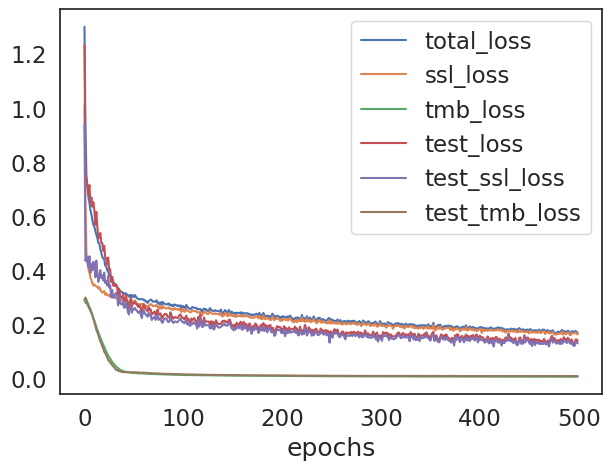

In [9]:
T.train(df_tpm_train, df_task_train, task_name, task_type, df_tpm_test, df_task_test)

100%|##########| 20/20 [00:00<00:00, 70.10it/s]
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


UMAP(n_neighbors=32, random_state=42, spread=5, verbose=1)
Tue Oct 17 15:50:56 2023 Construct fuzzy simplicial set
Tue Oct 17 15:50:56 2023 Finding Nearest Neighbors
Tue Oct 17 15:50:56 2023 Building RP forest with 10 trees
Tue Oct 17 15:50:59 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Tue Oct 17 15:51:23 2023 Finished Nearest Neighbor Search
Tue Oct 17 15:51:24 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Oct 17 15:51:36 2023 Finished embedding


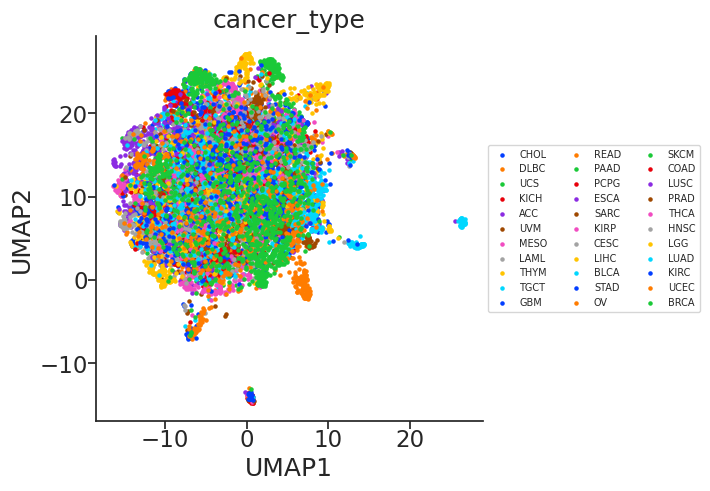

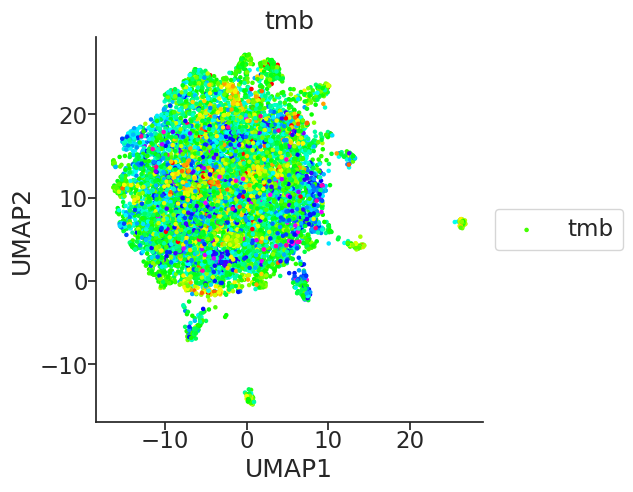

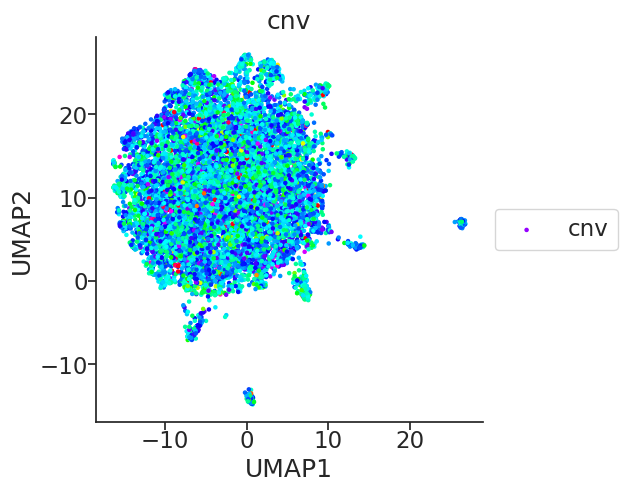

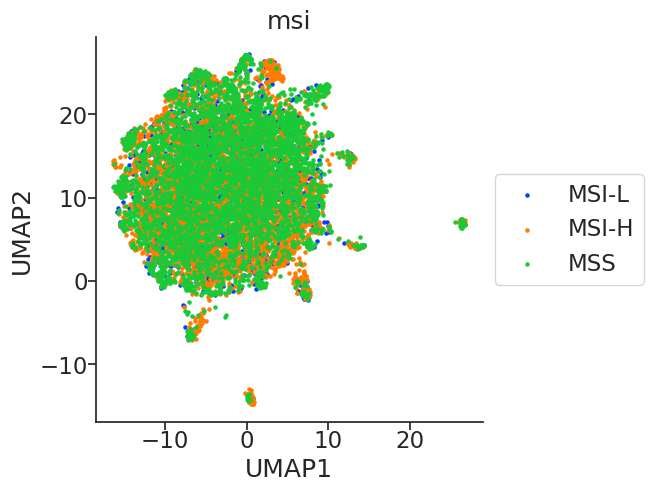

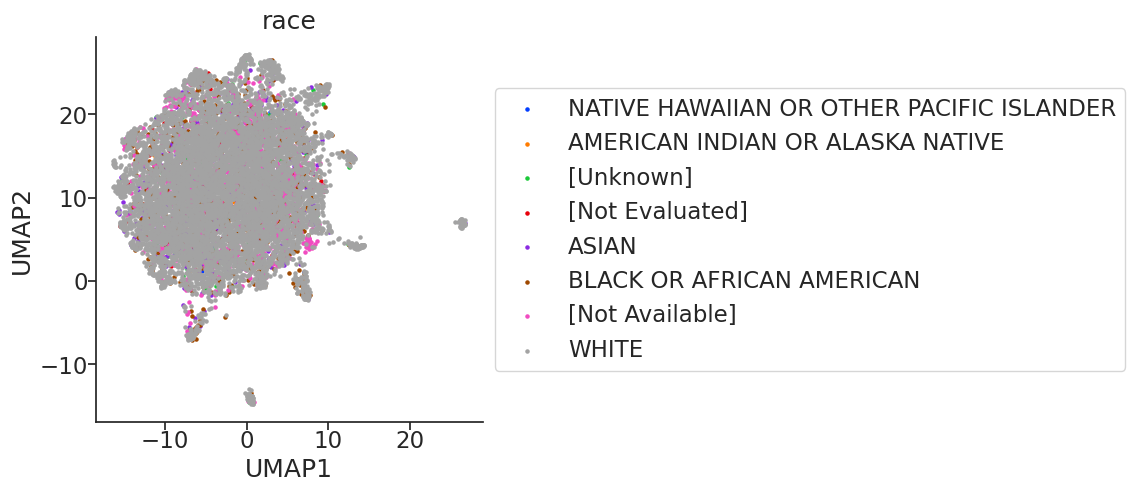

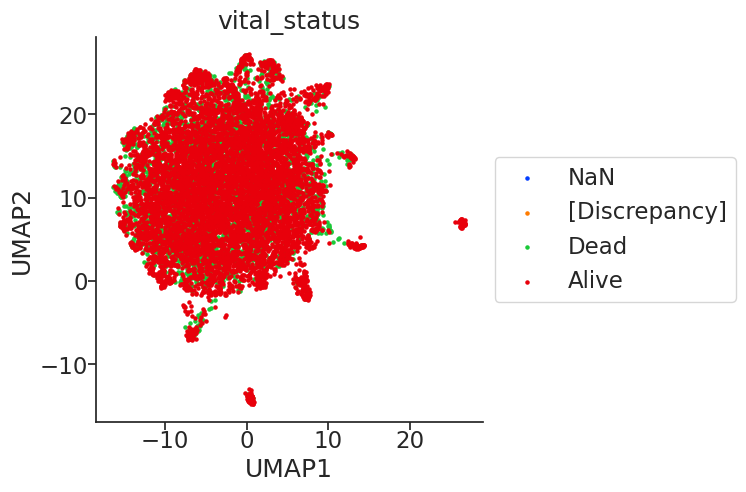

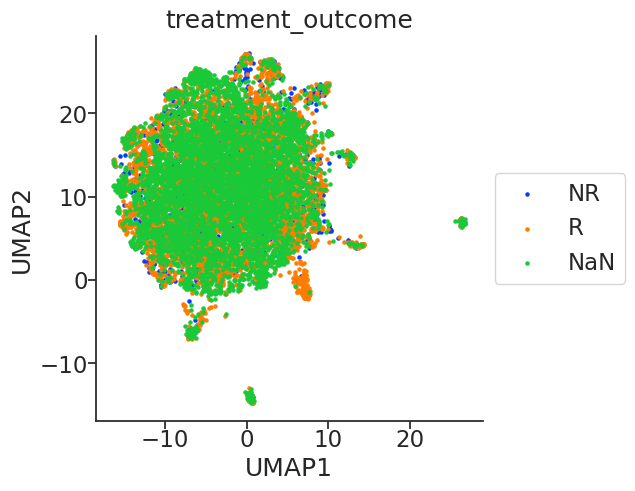

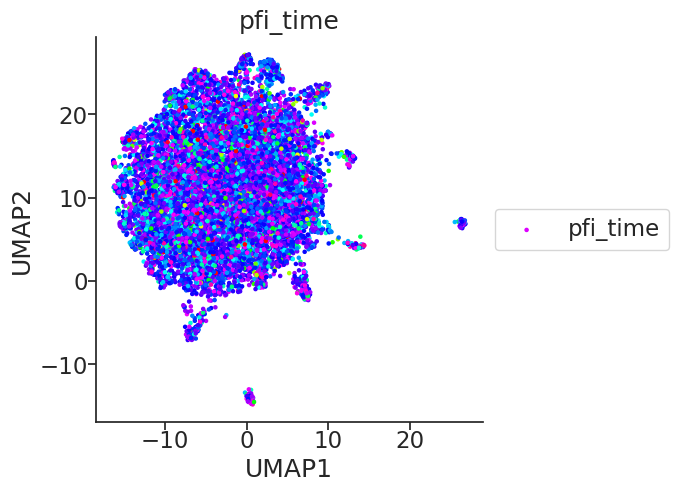

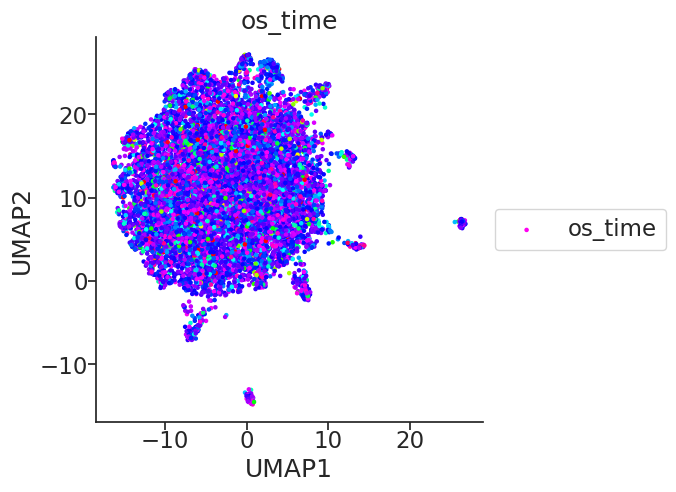

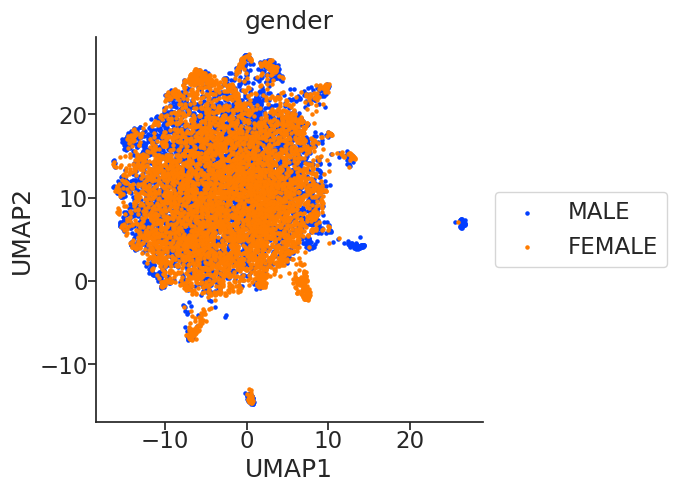

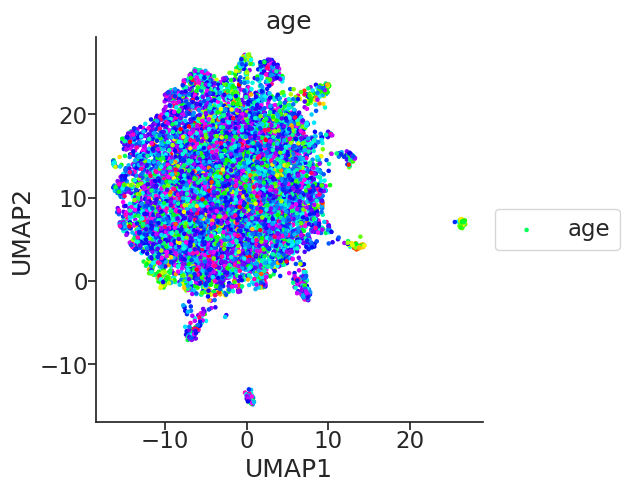

In [10]:
dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', '')).to_frame()
msi = tcga_label[['msi']]
cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')

l1 = tcga_label[['race', 'vital_status', 'treatment_outcome']].fillna('NaN')
l2 = np.log10(tcga_label[['pfi_time', 'os_time']]+1)
l3 = tcga_label[['gender', 'age',]]
df_label = dfc.join(df_tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)
label_col = ['cancer_type', 'tmb', 'cnv', 'msi', 'race', 'vital_status',
       'treatment_outcome', 'pfi_time', 'os_time', 'gender', 'age']

label_type = ['c', 'r', 'r', 'c',  'c', 'c', 'c',  'r',  'r', 'c', 'r',]
T.plot_embed(df_tpm, df_label, label_type, s=5,figsize=(5,5), spread = 5)

/tmp/ipykernel_6476/1094031470.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']
100%|##########| 1/1 [00:00<00:00,  4.19it/s]


UMAP(n_neighbors=32, random_state=42, spread=1, verbose=1)
Tue Oct 17 15:51:43 2023 Construct fuzzy simplicial set
Tue Oct 17 15:51:43 2023 Finding Nearest Neighbors
Tue Oct 17 15:51:45 2023 Finished Nearest Neighbor Search
Tue Oct 17 15:51:45 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Oct 17 15:51:47 2023 Finished embedding


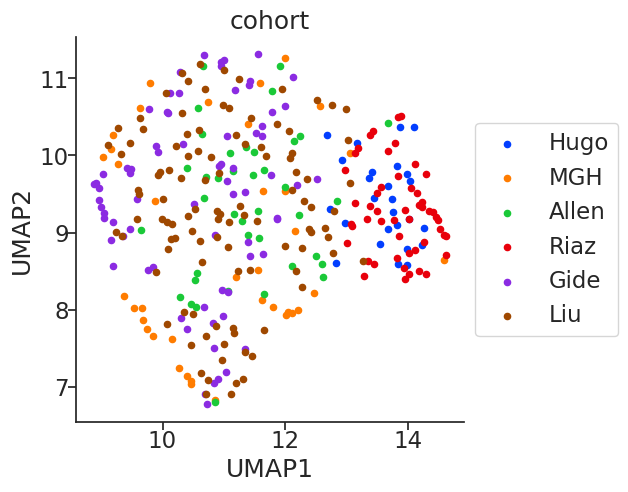

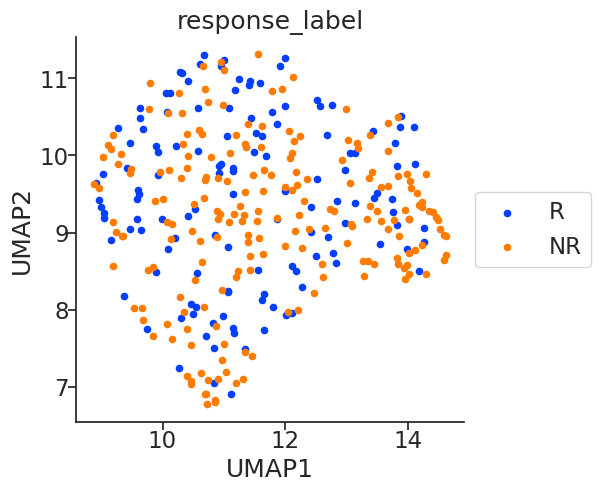

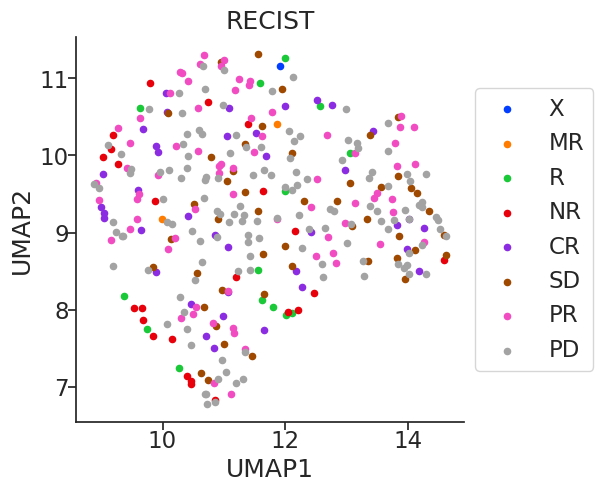

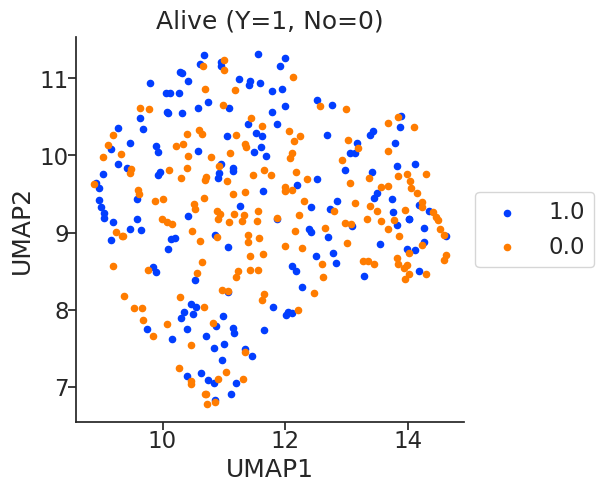

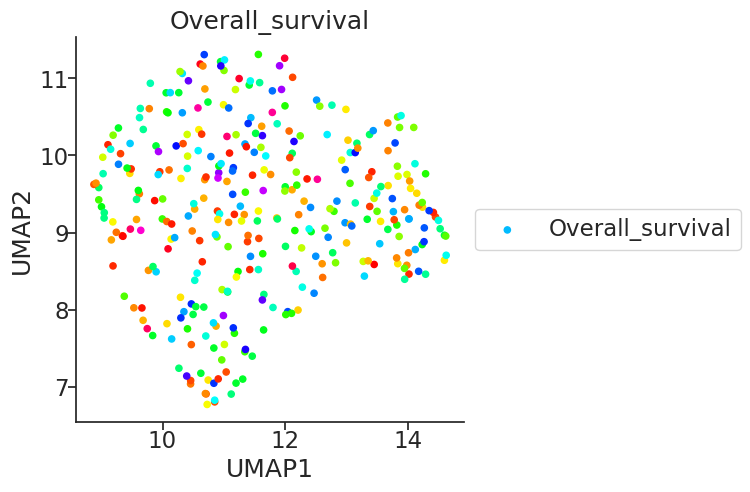

In [11]:
### make prediction & plot on ITRP
itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
itrp_meta['response_label'] = itrp_meta['Freeman_response']
itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']
itrp_y = itrp_meta[['response_label']]
itrp_c = itrp_meta[['cohort']]
itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T

label_col = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
df_label = itrp_meta[label_col]
label_type = ['c', 'c', 'c', 'c', 'r']

T.plot_embed(itrp_x, df_label, label_type, s=20, figsize=(5,5))


In [14]:
#aggmapcnn